In [67]:
#original code https://github.com/enakai00/autoencoder_example

import tensorflow as tf
import os,shutil
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.python.estimator.model_fn import ModeKeys as Modes
from tensorflow.contrib.learn import Experiment
from tensorflow.contrib.learn.python.learn import learn_runner
from tensorflow.contrib.learn.python.learn.utils import (saved_model_export_utils)

tf.logging.set_verbosity(tf.logging.INFO)

OUTDIR='/tmp/trained_model'

#
# definining queue
#
def read_and_decode(filename_queue):
    reader = tf.TFRecordReader()
    _,serialized_example = reader.read(filename_queue)
    
    features = tf.parse_single_example(
        serialized_example,
        features={
            'image_raw':tf.FixedLenFeature([],tf.string),
            'label':tf.FixedLenFeature([],tf.int64),
        })
    
    image = tf.decode_raw(features['image_raw'],tf.uint8)
    image.set_shape([784]) #image shape is (784,)
    image = tf.cast(image,tf.float32)*(1.0/255)
    label = tf.cast(features['label'],tf.int32)
    
    return image,label

def input_fn(filename,batch_size=100):
    filename_queue = tf.train.string_input_producer([filename])
    
    image,label = read_and_decode(filename_queue)
    images,labels = tf.train.batch(
        [image,label],batch_size=batch_size,
        capacity=1000+3*batch_size)
    #images : (100,784), labels : (100,1)
    
    return {'inputs':images},labels

def get_input_fn(filename,batch_size=100):
    return lambda: input_fn(filename,batch_size)

def serving_input_fn():
    inputs = {'inputs':tf.placeholder(tf.float32,[None,784])}
    return tf.estimator.export.ServingInputReceiver(inputs,inputs)

#
# define model
#
def autoencoder_model_fn(features,labels,mode):
    input_layer = features['inputs']
    dense1 = tf.layers.dense(inputs=input_layer,units=256,activation=tf.nn.relu)
    dense2 = tf.layers.dense(inputs=dense1,units=128,activation=tf.nn.relu)
    dense3 = tf.layers.dense(inputs=dense2,units=16,activation=tf.nn.relu)
    dense4 = tf.layers.dense(inputs=dense3,units=128,activation=tf.nn.relu)
    dense5 = tf.layers.dense(inputs=dense4,units=256,activation=tf.nn.relu)
    output_layer = tf.layers.dense(inputs=dense5,units=784,activation=tf.nn.sigmoid)
    
    #training and evaluation mode
    if mode in (Modes.TRAIN,Modes.EVAL):
        global_step = tf.contrib.framework.get_or_create_global_step()
        label_indices = tf.cast(labels,tf.int32)
        loss = tf.reduce_sum(tf.square(output_layer - input_layer))
        tf.summary.scalar('OptimizeLoss',loss)

        if mode == Modes.TRAIN:
            optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
            train_op = optimizer.minimize(loss,global_step=global_step)
            return tf.estimator.EstimatorSpec(mode,loss = loss, train_op = train_op)
        if mode == Modes.EVAL:
            eval_metric_ops = None
            return tf.estimator.EstimatorSpec(
                mode,loss=loss,eval_metric_ops = eval_metric_ops)
        
    # prediction mode
    if mode == Modes.PREDICT:
        predictions={
            'outputs':output_layer
        }
        export_outputs={
            'outputs':tf.estimator.export.PredictOutput(predictions)
        }
        return tf.estimator.EstimatorSpec(
            mode,predictions=predictions,export_outputs=export_outputs) #이부분 코드 상세 조사할것
    

def build_estimator(model_dir):
    return tf.estimator.Estimator(
        model_fn = autoencoder_model_fn,
        model_dir = model_dir,
        config=tf.contrib.learn.RunConfig(save_checkpoints_secs=180))

def generate_experiment_fn(data_dir,
                          train_batch_size = 100,
                          eval_batch_size = 100,
                          train_steps = 1000,
                          eval_steps = 1,
                          **experiment_args):
    def _experiment_fn(output_dir):
        return Experiment(
            build_estimator(output_dir),
            train_input_fn=get_input_fn('./data/train.tfrecords',batch_size=train_batch_size),
            eval_input_fn=get_input_fn('./data/test.tfrecords',batch_size=eval_batch_size),
            export_strategies = [saved_model_export_utils.make_export_strategy(
                serving_input_fn,
                default_output_alternative_key=None,
                exports_to_keep=1)
            ],
            train_steps = train_steps,
            eval_steps = eval_steps,
            **experiment_args
        )
    return _experiment_fn

shutil.rmtree(OUTDIR, ignore_errors=True) # start fresh each time
learn_runner.run(
    generate_experiment_fn(
        data_dir='./data/',
        train_steps=50000),
    OUTDIR)
    

INFO:tensorflow:Using config: {'_save_checkpoints_secs': 180, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x11c3c1d90>, '_model_dir': '/tmp/trained_model', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': None, '_save_summary_steps': 100, '_environment': 'local', '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_evaluation_master': '', '_master': ''}
Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/trained_model/model.ckpt.
INFO:tensorflow:Starting evaluation at 2017-09-17-06:29:57
INFO:tensorflow:Restoring parameters from /tmp/trained_model/model.ckpt-1
INFO:tensorflow:Eval

INFO:tensorflow:global_step/sec: 66.8995
INFO:tensorflow:loss = 846.848, step = 7001 (1.495 sec)
INFO:tensorflow:global_step/sec: 63.8828
INFO:tensorflow:loss = 794.73, step = 7101 (1.565 sec)
INFO:tensorflow:global_step/sec: 61.2006
INFO:tensorflow:loss = 749.796, step = 7201 (1.634 sec)
INFO:tensorflow:global_step/sec: 63.6454
INFO:tensorflow:loss = 781.262, step = 7301 (1.571 sec)
INFO:tensorflow:global_step/sec: 65.0514
INFO:tensorflow:loss = 789.007, step = 7401 (1.537 sec)
INFO:tensorflow:global_step/sec: 64.4763
INFO:tensorflow:loss = 784.231, step = 7501 (1.551 sec)
INFO:tensorflow:global_step/sec: 65.6162
INFO:tensorflow:loss = 812.414, step = 7601 (1.524 sec)
INFO:tensorflow:global_step/sec: 67.6992
INFO:tensorflow:loss = 789.992, step = 7701 (1.477 sec)
INFO:tensorflow:global_step/sec: 59.7002
INFO:tensorflow:loss = 748.211, step = 7801 (1.675 sec)
INFO:tensorflow:global_step/sec: 64.0618
INFO:tensorflow:loss = 816.161, step = 7901 (1.561 sec)
INFO:tensorflow:global_step/sec

INFO:tensorflow:loss = 791.482, step = 14901 (1.550 sec)
INFO:tensorflow:global_step/sec: 61.7094
INFO:tensorflow:loss = 641.561, step = 15001 (1.621 sec)
INFO:tensorflow:global_step/sec: 60.9562
INFO:tensorflow:loss = 624.113, step = 15101 (1.639 sec)
INFO:tensorflow:global_step/sec: 65.569
INFO:tensorflow:loss = 723.21, step = 15201 (1.525 sec)
INFO:tensorflow:global_step/sec: 63.6545
INFO:tensorflow:loss = 687.321, step = 15301 (1.571 sec)
INFO:tensorflow:global_step/sec: 64.2194
INFO:tensorflow:loss = 595.37, step = 15401 (1.557 sec)
INFO:tensorflow:global_step/sec: 64.706
INFO:tensorflow:loss = 759.259, step = 15501 (1.545 sec)
INFO:tensorflow:global_step/sec: 63.3258
INFO:tensorflow:loss = 598.943, step = 15601 (1.579 sec)
INFO:tensorflow:global_step/sec: 60.2018
INFO:tensorflow:loss = 609.526, step = 15701 (1.661 sec)
INFO:tensorflow:global_step/sec: 63.6622
INFO:tensorflow:loss = 720.803, step = 15801 (1.570 sec)
INFO:tensorflow:global_step/sec: 64.7742
INFO:tensorflow:loss = 6

INFO:tensorflow:loss = 654.398, step = 22801 (1.726 sec)
INFO:tensorflow:global_step/sec: 60.0871
INFO:tensorflow:loss = 599.742, step = 22901 (1.665 sec)
INFO:tensorflow:global_step/sec: 60.935
INFO:tensorflow:loss = 531.222, step = 23001 (1.642 sec)
INFO:tensorflow:global_step/sec: 59.9949
INFO:tensorflow:loss = 678.912, step = 23101 (1.666 sec)
INFO:tensorflow:global_step/sec: 59.422
INFO:tensorflow:loss = 696.313, step = 23201 (1.683 sec)
INFO:tensorflow:global_step/sec: 57.0785
INFO:tensorflow:loss = 760.23, step = 23301 (1.752 sec)
INFO:tensorflow:global_step/sec: 59.0349
INFO:tensorflow:loss = 648.687, step = 23401 (1.693 sec)
INFO:tensorflow:global_step/sec: 58.7008
INFO:tensorflow:loss = 610.422, step = 23501 (1.704 sec)
INFO:tensorflow:global_step/sec: 61.2781
INFO:tensorflow:loss = 520.341, step = 23601 (1.632 sec)
INFO:tensorflow:global_step/sec: 62.7766
INFO:tensorflow:loss = 679.33, step = 23701 (1.593 sec)
INFO:tensorflow:global_step/sec: 60.9162
INFO:tensorflow:loss = 6

INFO:tensorflow:loss = 644.875, step = 31201 (2.046 sec)
INFO:tensorflow:global_step/sec: 55.8218
INFO:tensorflow:loss = 561.389, step = 31301 (1.791 sec)
INFO:tensorflow:global_step/sec: 61.293
INFO:tensorflow:loss = 603.905, step = 31401 (1.632 sec)
INFO:tensorflow:global_step/sec: 61.1657
INFO:tensorflow:loss = 588.977, step = 31501 (1.635 sec)
INFO:tensorflow:global_step/sec: 61.7346
INFO:tensorflow:loss = 673.87, step = 31601 (1.620 sec)
INFO:tensorflow:global_step/sec: 63.7145
INFO:tensorflow:loss = 671.547, step = 31701 (1.569 sec)
INFO:tensorflow:global_step/sec: 64.0343
INFO:tensorflow:loss = 651.368, step = 31801 (1.562 sec)
INFO:tensorflow:global_step/sec: 60.963
INFO:tensorflow:loss = 579.262, step = 31901 (1.640 sec)
INFO:tensorflow:global_step/sec: 64.6073
INFO:tensorflow:loss = 638.074, step = 32001 (1.548 sec)
INFO:tensorflow:global_step/sec: 63.2351
INFO:tensorflow:loss = 598.887, step = 32101 (1.581 sec)
INFO:tensorflow:global_step/sec: 63.1786
INFO:tensorflow:loss = 

INFO:tensorflow:loss = 612.304, step = 39101 (1.633 sec)
INFO:tensorflow:global_step/sec: 64.3211
INFO:tensorflow:loss = 551.979, step = 39201 (1.554 sec)
INFO:tensorflow:global_step/sec: 62.0114
INFO:tensorflow:loss = 608.547, step = 39301 (1.613 sec)
INFO:tensorflow:global_step/sec: 64.2415
INFO:tensorflow:loss = 620.34, step = 39401 (1.557 sec)
INFO:tensorflow:global_step/sec: 64.986
INFO:tensorflow:loss = 690.273, step = 39501 (1.538 sec)
INFO:tensorflow:global_step/sec: 65.2517
INFO:tensorflow:loss = 598.159, step = 39601 (1.533 sec)
INFO:tensorflow:global_step/sec: 64.0661
INFO:tensorflow:loss = 637.124, step = 39701 (1.561 sec)
INFO:tensorflow:global_step/sec: 61.9706
INFO:tensorflow:loss = 519.294, step = 39801 (1.614 sec)
INFO:tensorflow:global_step/sec: 63.1307
INFO:tensorflow:loss = 611.21, step = 39901 (1.583 sec)
INFO:tensorflow:global_step/sec: 63.4656
INFO:tensorflow:loss = 617.53, step = 40001 (1.575 sec)
INFO:tensorflow:global_step/sec: 65.0283
INFO:tensorflow:loss = 6

INFO:tensorflow:global_step/sec: 62.0648
INFO:tensorflow:loss = 719.125, step = 47101 (1.611 sec)
INFO:tensorflow:global_step/sec: 59.1993
INFO:tensorflow:loss = 554.097, step = 47201 (1.689 sec)
INFO:tensorflow:global_step/sec: 57.03
INFO:tensorflow:loss = 552.197, step = 47301 (1.754 sec)
INFO:tensorflow:global_step/sec: 57.472
INFO:tensorflow:loss = 545.453, step = 47401 (1.740 sec)
INFO:tensorflow:global_step/sec: 55.9569
INFO:tensorflow:loss = 488.463, step = 47501 (1.787 sec)
INFO:tensorflow:global_step/sec: 52.2606
INFO:tensorflow:loss = 593.918, step = 47601 (1.914 sec)
INFO:tensorflow:global_step/sec: 55.4174
INFO:tensorflow:loss = 728.126, step = 47701 (1.804 sec)
INFO:tensorflow:global_step/sec: 56.7362
INFO:tensorflow:loss = 560.159, step = 47801 (1.763 sec)
INFO:tensorflow:global_step/sec: 56.4387
INFO:tensorflow:loss = 576.26, step = 47901 (1.772 sec)
INFO:tensorflow:global_step/sec: 56.248
INFO:tensorflow:loss = 554.555, step = 48001 (1.778 sec)
INFO:tensorflow:global_st

INFO:tensorflow:global_step/sec: 62.4454
INFO:tensorflow:loss = 611.883, step = 55501 (1.601 sec)
INFO:tensorflow:global_step/sec: 64.5241
INFO:tensorflow:loss = 576.51, step = 55601 (1.550 sec)
INFO:tensorflow:global_step/sec: 65.3284
INFO:tensorflow:loss = 577.632, step = 55701 (1.531 sec)
INFO:tensorflow:global_step/sec: 65.5774
INFO:tensorflow:loss = 595.106, step = 55801 (1.525 sec)
INFO:tensorflow:global_step/sec: 63.9941
INFO:tensorflow:loss = 595.956, step = 55901 (1.563 sec)
INFO:tensorflow:Saving checkpoints for 55944 into /tmp/trained_model/model.ckpt.
INFO:tensorflow:Starting evaluation at 2017-09-17-06:44:57
INFO:tensorflow:Restoring parameters from /tmp/trained_model/model.ckpt-55944
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-09-17-06:44:58
INFO:tensorflow:Saving dict for global step 55944: global_step = 55944, loss = 703.109
INFO:tensorflow:Validation (step 55944): loss = 703.109, global_step = 55944
INFO:tensorflow:global_step/sec: 34.4

INFO:tensorflow:global_step/sec: 61.4046
INFO:tensorflow:loss = 564.043, step = 63401 (1.628 sec)
INFO:tensorflow:global_step/sec: 63.7008
INFO:tensorflow:loss = 541.449, step = 63501 (1.570 sec)
INFO:tensorflow:global_step/sec: 64.5375
INFO:tensorflow:loss = 671.434, step = 63601 (1.550 sec)
INFO:tensorflow:global_step/sec: 65.0557
INFO:tensorflow:loss = 533.096, step = 63701 (1.537 sec)
INFO:tensorflow:global_step/sec: 61.8304
INFO:tensorflow:loss = 523.259, step = 63801 (1.617 sec)
INFO:tensorflow:global_step/sec: 63.3258
INFO:tensorflow:loss = 625.977, step = 63901 (1.580 sec)
INFO:tensorflow:global_step/sec: 62.7182
INFO:tensorflow:loss = 552.184, step = 64001 (1.594 sec)
INFO:tensorflow:global_step/sec: 63.3337
INFO:tensorflow:loss = 560.224, step = 64101 (1.579 sec)
INFO:tensorflow:global_step/sec: 65.4555
INFO:tensorflow:loss = 677.026, step = 64201 (1.528 sec)
INFO:tensorflow:global_step/sec: 63.383
INFO:tensorflow:loss = 537.658, step = 64301 (1.578 sec)
INFO:tensorflow:globa

INFO:tensorflow:global_step/sec: 63.5027
INFO:tensorflow:loss = 535.162, step = 71301 (1.575 sec)
INFO:tensorflow:global_step/sec: 66.611
INFO:tensorflow:loss = 677.631, step = 71401 (1.501 sec)
INFO:tensorflow:global_step/sec: 64.168
INFO:tensorflow:loss = 525.857, step = 71501 (1.558 sec)
INFO:tensorflow:global_step/sec: 62.5652
INFO:tensorflow:loss = 530.94, step = 71601 (1.599 sec)
INFO:tensorflow:global_step/sec: 63.5235
INFO:tensorflow:loss = 617.413, step = 71701 (1.574 sec)
INFO:tensorflow:global_step/sec: 63.2609
INFO:tensorflow:loss = 675.381, step = 71801 (1.581 sec)
INFO:tensorflow:global_step/sec: 61.679
INFO:tensorflow:loss = 550.492, step = 71901 (1.622 sec)
INFO:tensorflow:global_step/sec: 64.4878
INFO:tensorflow:loss = 662.202, step = 72001 (1.550 sec)
INFO:tensorflow:global_step/sec: 63.4704
INFO:tensorflow:loss = 553.498, step = 72101 (1.575 sec)
INFO:tensorflow:global_step/sec: 62.3006
INFO:tensorflow:loss = 541.905, step = 72201 (1.606 sec)
INFO:tensorflow:global_s

INFO:tensorflow:loss = 560.369, step = 79201 (1.588 sec)
INFO:tensorflow:global_step/sec: 63.7892
INFO:tensorflow:loss = 563.823, step = 79301 (1.568 sec)
INFO:tensorflow:global_step/sec: 64.908
INFO:tensorflow:loss = 580.092, step = 79401 (1.541 sec)
INFO:tensorflow:global_step/sec: 62.2407
INFO:tensorflow:loss = 514.969, step = 79501 (1.606 sec)
INFO:tensorflow:global_step/sec: 62.5236
INFO:tensorflow:loss = 665.706, step = 79601 (1.600 sec)
INFO:tensorflow:global_step/sec: 65.7044
INFO:tensorflow:loss = 599.071, step = 79701 (1.522 sec)
INFO:tensorflow:global_step/sec: 64.1135
INFO:tensorflow:loss = 569.549, step = 79801 (1.560 sec)
INFO:tensorflow:global_step/sec: 61.5186
INFO:tensorflow:loss = 557.332, step = 79901 (1.626 sec)
INFO:tensorflow:global_step/sec: 63.635
INFO:tensorflow:loss = 589.634, step = 80001 (1.572 sec)
INFO:tensorflow:global_step/sec: 62.018
INFO:tensorflow:loss = 521.28, step = 80101 (1.612 sec)
INFO:tensorflow:global_step/sec: 63.3065
INFO:tensorflow:loss = 6

INFO:tensorflow:loss = 627.183, step = 87601 (1.550 sec)
INFO:tensorflow:global_step/sec: 60.7672
INFO:tensorflow:loss = 531.013, step = 87701 (1.646 sec)
INFO:tensorflow:global_step/sec: 59.5469
INFO:tensorflow:loss = 559.867, step = 87801 (1.680 sec)
INFO:tensorflow:global_step/sec: 61.6818
INFO:tensorflow:loss = 628.857, step = 87901 (1.621 sec)
INFO:tensorflow:global_step/sec: 59.1463
INFO:tensorflow:loss = 537.325, step = 88001 (1.691 sec)
INFO:tensorflow:global_step/sec: 61.6218
INFO:tensorflow:loss = 537.9, step = 88101 (1.623 sec)
INFO:tensorflow:global_step/sec: 61.1981
INFO:tensorflow:loss = 613.867, step = 88201 (1.634 sec)
INFO:tensorflow:global_step/sec: 61.5576
INFO:tensorflow:loss = 552.084, step = 88301 (1.624 sec)
INFO:tensorflow:global_step/sec: 58.9739
INFO:tensorflow:loss = 579.937, step = 88401 (1.696 sec)
INFO:tensorflow:global_step/sec: 58.8848
INFO:tensorflow:loss = 634.97, step = 88501 (1.698 sec)
INFO:tensorflow:global_step/sec: 61.6094
INFO:tensorflow:loss = 

INFO:tensorflow:loss = 546.172, step = 95501 (1.567 sec)
INFO:tensorflow:global_step/sec: 63.5814
INFO:tensorflow:loss = 493.494, step = 95601 (1.572 sec)
INFO:tensorflow:global_step/sec: 66.1343
INFO:tensorflow:loss = 627.014, step = 95701 (1.512 sec)
INFO:tensorflow:global_step/sec: 65.4308
INFO:tensorflow:loss = 559.2, step = 95801 (1.528 sec)
INFO:tensorflow:global_step/sec: 64.4378
INFO:tensorflow:loss = 597.374, step = 95901 (1.552 sec)
INFO:tensorflow:global_step/sec: 59.5848
INFO:tensorflow:loss = 519.382, step = 96001 (1.678 sec)
INFO:tensorflow:global_step/sec: 63.4062
INFO:tensorflow:loss = 568.138, step = 96101 (1.577 sec)
INFO:tensorflow:global_step/sec: 65.3222
INFO:tensorflow:loss = 483.996, step = 96201 (1.531 sec)
INFO:tensorflow:global_step/sec: 66.3538
INFO:tensorflow:loss = 649.389, step = 96301 (1.507 sec)
INFO:tensorflow:global_step/sec: 65.6191
INFO:tensorflow:loss = 559.725, step = 96401 (1.524 sec)
INFO:tensorflow:global_step/sec: 65.0695
INFO:tensorflow:loss =

INFO:tensorflow:global_step/sec: 63.4299
INFO:tensorflow:loss = 569.0, step = 103401 (1.577 sec)
INFO:tensorflow:global_step/sec: 64.0118
INFO:tensorflow:loss = 616.254, step = 103501 (1.562 sec)
INFO:tensorflow:global_step/sec: 64.5234
INFO:tensorflow:loss = 519.444, step = 103601 (1.550 sec)
INFO:tensorflow:global_step/sec: 63.9537
INFO:tensorflow:loss = 532.061, step = 103701 (1.563 sec)
INFO:tensorflow:global_step/sec: 62.5942
INFO:tensorflow:loss = 506.033, step = 103801 (1.598 sec)
INFO:tensorflow:global_step/sec: 62.878
INFO:tensorflow:loss = 534.242, step = 103901 (1.591 sec)
INFO:tensorflow:global_step/sec: 62.2814
INFO:tensorflow:loss = 559.109, step = 104001 (1.605 sec)
INFO:tensorflow:global_step/sec: 64.1001
INFO:tensorflow:loss = 603.935, step = 104101 (1.560 sec)
INFO:tensorflow:global_step/sec: 63.7501
INFO:tensorflow:loss = 525.552, step = 104201 (1.570 sec)
INFO:tensorflow:global_step/sec: 65.3591
INFO:tensorflow:loss = 515.224, step = 104301 (1.528 sec)
INFO:tensorfl

INFO:tensorflow:global_step/sec: 59.9426
INFO:tensorflow:loss = 519.443, step = 111701 (1.669 sec)
INFO:tensorflow:global_step/sec: 59.8628
INFO:tensorflow:loss = 524.525, step = 111801 (1.670 sec)
INFO:tensorflow:global_step/sec: 60.698
INFO:tensorflow:loss = 593.395, step = 111901 (1.648 sec)
INFO:tensorflow:global_step/sec: 59.4669
INFO:tensorflow:loss = 557.657, step = 112001 (1.682 sec)
INFO:tensorflow:global_step/sec: 61.7087
INFO:tensorflow:loss = 571.076, step = 112101 (1.620 sec)
INFO:tensorflow:Saving checkpoints for 112110 into /tmp/trained_model/model.ckpt.
INFO:tensorflow:Starting evaluation at 2017-09-17-06:59:58
INFO:tensorflow:Restoring parameters from /tmp/trained_model/model.ckpt-112110
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-09-17-06:59:58
INFO:tensorflow:Saving dict for global step 112110: global_step = 112110, loss = 666.714
INFO:tensorflow:Validation (step 112110): loss = 666.714, global_step = 112110
INFO:tensorflow:global_ste

INFO:tensorflow:global_step/sec: 63.5707
INFO:tensorflow:loss = 528.454, step = 119501 (1.573 sec)
INFO:tensorflow:global_step/sec: 64.0179
INFO:tensorflow:loss = 599.9, step = 119601 (1.562 sec)
INFO:tensorflow:global_step/sec: 64.3339
INFO:tensorflow:loss = 639.646, step = 119701 (1.554 sec)
INFO:tensorflow:global_step/sec: 65.0803
INFO:tensorflow:loss = 558.165, step = 119801 (1.537 sec)
INFO:tensorflow:global_step/sec: 62.3329
INFO:tensorflow:loss = 644.433, step = 119901 (1.604 sec)
INFO:tensorflow:global_step/sec: 64.3848
INFO:tensorflow:loss = 545.915, step = 120001 (1.553 sec)
INFO:tensorflow:global_step/sec: 63.2336
INFO:tensorflow:loss = 521.863, step = 120101 (1.582 sec)
INFO:tensorflow:global_step/sec: 63.5174
INFO:tensorflow:loss = 595.783, step = 120201 (1.574 sec)
INFO:tensorflow:global_step/sec: 64.7557
INFO:tensorflow:loss = 646.236, step = 120301 (1.545 sec)
INFO:tensorflow:global_step/sec: 66.5921
INFO:tensorflow:loss = 553.22, step = 120401 (1.501 sec)
INFO:tensorfl

INFO:tensorflow:loss = 486.476, step = 127301 (1.558 sec)
INFO:tensorflow:global_step/sec: 62.689
INFO:tensorflow:loss = 644.605, step = 127401 (1.595 sec)
INFO:tensorflow:global_step/sec: 64.0045
INFO:tensorflow:loss = 543.679, step = 127501 (1.562 sec)
INFO:tensorflow:global_step/sec: 64.3735
INFO:tensorflow:loss = 448.752, step = 127601 (1.553 sec)
INFO:tensorflow:global_step/sec: 64.3453
INFO:tensorflow:loss = 547.411, step = 127701 (1.554 sec)
INFO:tensorflow:global_step/sec: 62.6067
INFO:tensorflow:loss = 527.388, step = 127801 (1.597 sec)
INFO:tensorflow:global_step/sec: 65.1588
INFO:tensorflow:loss = 493.85, step = 127901 (1.535 sec)
INFO:tensorflow:global_step/sec: 61.723
INFO:tensorflow:loss = 631.082, step = 128001 (1.620 sec)
INFO:tensorflow:global_step/sec: 64.0349
INFO:tensorflow:loss = 538.189, step = 128101 (1.562 sec)
INFO:tensorflow:global_step/sec: 65.7369
INFO:tensorflow:loss = 453.704, step = 128201 (1.520 sec)
INFO:tensorflow:global_step/sec: 61.9582
INFO:tensorfl

INFO:tensorflow:global_step/sec: 59.6687
INFO:tensorflow:loss = 545.611, step = 135201 (1.675 sec)
INFO:tensorflow:global_step/sec: 60.3546
INFO:tensorflow:loss = 565.987, step = 135301 (1.657 sec)
INFO:tensorflow:global_step/sec: 61.3858
INFO:tensorflow:loss = 511.891, step = 135401 (1.629 sec)
INFO:tensorflow:global_step/sec: 62.8701
INFO:tensorflow:loss = 519.979, step = 135501 (1.591 sec)
INFO:tensorflow:global_step/sec: 63.5865
INFO:tensorflow:loss = 482.307, step = 135601 (1.572 sec)
INFO:tensorflow:global_step/sec: 60.002
INFO:tensorflow:loss = 557.873, step = 135701 (1.667 sec)
INFO:tensorflow:global_step/sec: 59.5699
INFO:tensorflow:loss = 564.188, step = 135801 (1.679 sec)
INFO:tensorflow:global_step/sec: 60.3678
INFO:tensorflow:loss = 556.298, step = 135901 (1.656 sec)
INFO:tensorflow:global_step/sec: 61.4403
INFO:tensorflow:loss = 508.605, step = 136001 (1.628 sec)
INFO:tensorflow:global_step/sec: 62.5252
INFO:tensorflow:loss = 508.095, step = 136101 (1.599 sec)
INFO:tensor

INFO:tensorflow:global_step/sec: 64.3436
INFO:tensorflow:loss = 535.924, step = 143501 (1.554 sec)
INFO:tensorflow:global_step/sec: 66.2586
INFO:tensorflow:loss = 535.33, step = 143601 (1.509 sec)
INFO:tensorflow:global_step/sec: 60.8674
INFO:tensorflow:loss = 600.572, step = 143701 (1.644 sec)
INFO:tensorflow:global_step/sec: 62.5114
INFO:tensorflow:loss = 637.132, step = 143801 (1.599 sec)
INFO:tensorflow:global_step/sec: 64.8908
INFO:tensorflow:loss = 545.343, step = 143901 (1.541 sec)
INFO:tensorflow:global_step/sec: 63.8047
INFO:tensorflow:loss = 483.725, step = 144001 (1.567 sec)
INFO:tensorflow:global_step/sec: 64.2882
INFO:tensorflow:loss = 538.928, step = 144101 (1.556 sec)
INFO:tensorflow:global_step/sec: 65.1071
INFO:tensorflow:loss = 564.355, step = 144201 (1.535 sec)
INFO:tensorflow:global_step/sec: 61.8151
INFO:tensorflow:loss = 592.487, step = 144301 (1.618 sec)
INFO:tensorflow:global_step/sec: 61.4128
INFO:tensorflow:loss = 654.203, step = 144401 (1.629 sec)
INFO:tensor

INFO:tensorflow:loss = 531.707, step = 151301 (1.513 sec)
INFO:tensorflow:global_step/sec: 64.7006
INFO:tensorflow:loss = 509.721, step = 151401 (1.546 sec)
INFO:tensorflow:global_step/sec: 64.2306
INFO:tensorflow:loss = 467.204, step = 151501 (1.557 sec)
INFO:tensorflow:global_step/sec: 61.4723
INFO:tensorflow:loss = 498.999, step = 151601 (1.627 sec)
INFO:tensorflow:global_step/sec: 62.7351
INFO:tensorflow:loss = 421.396, step = 151701 (1.594 sec)
INFO:tensorflow:global_step/sec: 63.9933
INFO:tensorflow:loss = 491.064, step = 151801 (1.563 sec)
INFO:tensorflow:global_step/sec: 63.5683
INFO:tensorflow:loss = 552.191, step = 151901 (1.573 sec)
INFO:tensorflow:global_step/sec: 65.4729
INFO:tensorflow:loss = 519.078, step = 152001 (1.527 sec)
INFO:tensorflow:global_step/sec: 64.747
INFO:tensorflow:loss = 493.727, step = 152101 (1.544 sec)
INFO:tensorflow:global_step/sec: 61.5485
INFO:tensorflow:loss = 514.333, step = 152201 (1.625 sec)
INFO:tensorflow:global_step/sec: 60.9549
INFO:tensor

INFO:tensorflow:global_step/sec: 56.4957
INFO:tensorflow:loss = 599.989, step = 159201 (1.770 sec)
INFO:tensorflow:global_step/sec: 60.9454
INFO:tensorflow:loss = 575.96, step = 159301 (1.641 sec)
INFO:tensorflow:global_step/sec: 62.5133
INFO:tensorflow:loss = 625.402, step = 159401 (1.600 sec)
INFO:tensorflow:global_step/sec: 60.8459
INFO:tensorflow:loss = 532.653, step = 159501 (1.644 sec)
INFO:tensorflow:global_step/sec: 58.7652
INFO:tensorflow:loss = 576.111, step = 159601 (1.702 sec)
INFO:tensorflow:global_step/sec: 61.3506
INFO:tensorflow:loss = 602.363, step = 159701 (1.630 sec)
INFO:tensorflow:global_step/sec: 58.4715
INFO:tensorflow:loss = 578.645, step = 159801 (1.710 sec)
INFO:tensorflow:global_step/sec: 61.3852
INFO:tensorflow:loss = 570.785, step = 159901 (1.629 sec)
INFO:tensorflow:global_step/sec: 62.5438
INFO:tensorflow:loss = 588.124, step = 160001 (1.599 sec)
INFO:tensorflow:global_step/sec: 59.6668
INFO:tensorflow:loss = 532.084, step = 160101 (1.677 sec)
INFO:tensor

INFO:tensorflow:global_step/sec: 63.5736
INFO:tensorflow:loss = 541.851, step = 167501 (1.573 sec)
INFO:tensorflow:global_step/sec: 62.8591
INFO:tensorflow:loss = 500.054, step = 167601 (1.591 sec)
INFO:tensorflow:global_step/sec: 65.5133
INFO:tensorflow:loss = 514.715, step = 167701 (1.527 sec)
INFO:tensorflow:global_step/sec: 65.1446
INFO:tensorflow:loss = 522.595, step = 167801 (1.535 sec)
INFO:tensorflow:global_step/sec: 64.5317
INFO:tensorflow:loss = 584.202, step = 167901 (1.550 sec)
INFO:tensorflow:global_step/sec: 63.9678
INFO:tensorflow:loss = 604.613, step = 168001 (1.563 sec)
INFO:tensorflow:global_step/sec: 63.7424
INFO:tensorflow:loss = 565.7, step = 168101 (1.569 sec)
INFO:tensorflow:Saving checkpoints for 168169 into /tmp/trained_model/model.ckpt.
INFO:tensorflow:Starting evaluation at 2017-09-17-07:14:58
INFO:tensorflow:Restoring parameters from /tmp/trained_model/model.ckpt-168169
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-09-17-07:14:

INFO:tensorflow:loss = 590.604, step = 175301 (1.543 sec)
INFO:tensorflow:global_step/sec: 63.2842
INFO:tensorflow:loss = 566.855, step = 175401 (1.580 sec)
INFO:tensorflow:global_step/sec: 64.6967
INFO:tensorflow:loss = 516.955, step = 175501 (1.546 sec)
INFO:tensorflow:global_step/sec: 62.5268
INFO:tensorflow:loss = 581.865, step = 175601 (1.600 sec)
INFO:tensorflow:global_step/sec: 64.5155
INFO:tensorflow:loss = 629.137, step = 175701 (1.550 sec)
INFO:tensorflow:global_step/sec: 62.2923
INFO:tensorflow:loss = 521.527, step = 175801 (1.605 sec)
INFO:tensorflow:global_step/sec: 64.2187
INFO:tensorflow:loss = 599.146, step = 175901 (1.557 sec)
INFO:tensorflow:global_step/sec: 63.7658
INFO:tensorflow:loss = 547.036, step = 176001 (1.569 sec)
INFO:tensorflow:global_step/sec: 64.3049
INFO:tensorflow:loss = 511.406, step = 176101 (1.554 sec)
INFO:tensorflow:global_step/sec: 62.2046
INFO:tensorflow:loss = 561.935, step = 176201 (1.608 sec)
INFO:tensorflow:global_step/sec: 62.3021
INFO:tenso

INFO:tensorflow:global_step/sec: 65.0768
INFO:tensorflow:loss = 520.109, step = 183201 (1.537 sec)
INFO:tensorflow:global_step/sec: 66.6198
INFO:tensorflow:loss = 482.47, step = 183301 (1.501 sec)
INFO:tensorflow:global_step/sec: 63.7199
INFO:tensorflow:loss = 527.888, step = 183401 (1.569 sec)
INFO:tensorflow:global_step/sec: 62.7754
INFO:tensorflow:loss = 548.061, step = 183501 (1.593 sec)
INFO:tensorflow:global_step/sec: 62.8016
INFO:tensorflow:loss = 481.724, step = 183601 (1.592 sec)
INFO:tensorflow:global_step/sec: 64.6799
INFO:tensorflow:loss = 544.197, step = 183701 (1.546 sec)
INFO:tensorflow:global_step/sec: 62.9109
INFO:tensorflow:loss = 513.145, step = 183801 (1.590 sec)
INFO:tensorflow:global_step/sec: 65.6704
INFO:tensorflow:loss = 479.493, step = 183901 (1.523 sec)
INFO:tensorflow:global_step/sec: 65.6868
INFO:tensorflow:loss = 494.974, step = 184001 (1.522 sec)
INFO:tensorflow:global_step/sec: 59.9303
INFO:tensorflow:loss = 538.988, step = 184101 (1.669 sec)
INFO:tensor

INFO:tensorflow:loss = 488.39, step = 191001 (1.593 sec)
INFO:tensorflow:global_step/sec: 65.0293
INFO:tensorflow:loss = 559.152, step = 191101 (1.538 sec)
INFO:tensorflow:global_step/sec: 64.9846
INFO:tensorflow:loss = 532.312, step = 191201 (1.539 sec)
INFO:tensorflow:global_step/sec: 61.0676
INFO:tensorflow:loss = 524.524, step = 191301 (1.637 sec)
INFO:tensorflow:global_step/sec: 59.9907
INFO:tensorflow:loss = 476.859, step = 191401 (1.668 sec)
INFO:tensorflow:global_step/sec: 59.7199
INFO:tensorflow:loss = 536.963, step = 191501 (1.673 sec)
INFO:tensorflow:global_step/sec: 61.1099
INFO:tensorflow:loss = 483.165, step = 191601 (1.636 sec)
INFO:tensorflow:global_step/sec: 61.9571
INFO:tensorflow:loss = 558.198, step = 191701 (1.614 sec)
INFO:tensorflow:global_step/sec: 61.7319
INFO:tensorflow:loss = 516.338, step = 191801 (1.620 sec)
INFO:tensorflow:global_step/sec: 61.3261
INFO:tensorflow:loss = 522.76, step = 191901 (1.630 sec)
INFO:tensorflow:global_step/sec: 60.0552
INFO:tensorf

INFO:tensorflow:loss = 505.163, step = 199301 (1.531 sec)
INFO:tensorflow:global_step/sec: 62.0595
INFO:tensorflow:loss = 547.304, step = 199401 (1.612 sec)
INFO:tensorflow:global_step/sec: 60.2911
INFO:tensorflow:loss = 510.238, step = 199501 (1.659 sec)
INFO:tensorflow:global_step/sec: 65.2329
INFO:tensorflow:loss = 536.281, step = 199601 (1.533 sec)
INFO:tensorflow:global_step/sec: 63.7291
INFO:tensorflow:loss = 441.06, step = 199701 (1.570 sec)
INFO:tensorflow:global_step/sec: 65.023
INFO:tensorflow:loss = 480.859, step = 199801 (1.537 sec)
INFO:tensorflow:global_step/sec: 63.6796
INFO:tensorflow:loss = 510.053, step = 199901 (1.571 sec)
INFO:tensorflow:global_step/sec: 63.8675
INFO:tensorflow:loss = 547.155, step = 200001 (1.565 sec)
INFO:tensorflow:global_step/sec: 61.9946
INFO:tensorflow:loss = 486.473, step = 200101 (1.613 sec)
INFO:tensorflow:global_step/sec: 62.9038
INFO:tensorflow:loss = 556.009, step = 200201 (1.590 sec)
INFO:tensorflow:global_step/sec: 64.752
INFO:tensorfl

INFO:tensorflow:global_step/sec: 63.3941
INFO:tensorflow:loss = 497.635, step = 207201 (1.577 sec)
INFO:tensorflow:global_step/sec: 60.7946
INFO:tensorflow:loss = 570.18, step = 207301 (1.645 sec)
INFO:tensorflow:global_step/sec: 63.8119
INFO:tensorflow:loss = 540.062, step = 207401 (1.567 sec)
INFO:tensorflow:global_step/sec: 64.9962
INFO:tensorflow:loss = 553.867, step = 207501 (1.538 sec)
INFO:tensorflow:global_step/sec: 65.2944
INFO:tensorflow:loss = 508.052, step = 207601 (1.532 sec)
INFO:tensorflow:global_step/sec: 63.6387
INFO:tensorflow:loss = 514.589, step = 207701 (1.572 sec)
INFO:tensorflow:global_step/sec: 63.4993
INFO:tensorflow:loss = 503.784, step = 207801 (1.574 sec)
INFO:tensorflow:global_step/sec: 64.5925
INFO:tensorflow:loss = 576.128, step = 207901 (1.549 sec)
INFO:tensorflow:global_step/sec: 59.8829
INFO:tensorflow:loss = 539.027, step = 208001 (1.669 sec)
INFO:tensorflow:global_step/sec: 65.5975
INFO:tensorflow:loss = 549.05, step = 208101 (1.525 sec)
INFO:tensorf

INFO:tensorflow:loss = 517.815, step = 215001 (1.599 sec)
INFO:tensorflow:global_step/sec: 62.0526
INFO:tensorflow:loss = 530.539, step = 215101 (1.611 sec)
INFO:tensorflow:global_step/sec: 63.4419
INFO:tensorflow:loss = 503.384, step = 215201 (1.577 sec)
INFO:tensorflow:global_step/sec: 61.9483
INFO:tensorflow:loss = 493.263, step = 215301 (1.614 sec)
INFO:tensorflow:global_step/sec: 63.8954
INFO:tensorflow:loss = 582.57, step = 215401 (1.565 sec)
INFO:tensorflow:global_step/sec: 63.5249
INFO:tensorflow:loss = 590.952, step = 215501 (1.574 sec)
INFO:tensorflow:global_step/sec: 62.5492
INFO:tensorflow:loss = 515.408, step = 215601 (1.599 sec)
INFO:tensorflow:global_step/sec: 62.9188
INFO:tensorflow:loss = 532.665, step = 215701 (1.589 sec)
INFO:tensorflow:global_step/sec: 63.5664
INFO:tensorflow:loss = 504.645, step = 215801 (1.573 sec)
INFO:tensorflow:global_step/sec: 62.0745
INFO:tensorflow:loss = 518.36, step = 215901 (1.611 sec)
INFO:tensorflow:global_step/sec: 63.8813
INFO:tensorf

INFO:tensorflow:loss = 566.584, step = 223301 (1.612 sec)
INFO:tensorflow:global_step/sec: 61.454
INFO:tensorflow:loss = 620.433, step = 223401 (1.627 sec)
INFO:tensorflow:global_step/sec: 60.8406
INFO:tensorflow:loss = 507.969, step = 223501 (1.644 sec)
INFO:tensorflow:global_step/sec: 64.1664
INFO:tensorflow:loss = 557.194, step = 223601 (1.558 sec)
INFO:tensorflow:global_step/sec: 64.546
INFO:tensorflow:loss = 488.375, step = 223701 (1.550 sec)
INFO:tensorflow:global_step/sec: 64.0985
INFO:tensorflow:loss = 610.056, step = 223801 (1.560 sec)
INFO:tensorflow:global_step/sec: 60.7579
INFO:tensorflow:loss = 567.293, step = 223901 (1.646 sec)
INFO:tensorflow:global_step/sec: 63.0691
INFO:tensorflow:loss = 639.094, step = 224001 (1.586 sec)
INFO:tensorflow:global_step/sec: 62.4084
INFO:tensorflow:loss = 524.361, step = 224101 (1.602 sec)
INFO:tensorflow:global_step/sec: 62.925
INFO:tensorflow:loss = 571.102, step = 224201 (1.590 sec)
INFO:tensorflow:global_step/sec: 64.4704
INFO:tensorfl

INFO:tensorflow:global_step/sec: 64.0277
INFO:tensorflow:loss = 573.781, step = 231201 (1.562 sec)
INFO:tensorflow:global_step/sec: 63.541
INFO:tensorflow:loss = 447.306, step = 231301 (1.574 sec)
INFO:tensorflow:global_step/sec: 64.457
INFO:tensorflow:loss = 521.5, step = 231401 (1.552 sec)
INFO:tensorflow:global_step/sec: 63.8941
INFO:tensorflow:loss = 569.362, step = 231501 (1.565 sec)
INFO:tensorflow:global_step/sec: 65.477
INFO:tensorflow:loss = 544.202, step = 231601 (1.527 sec)
INFO:tensorflow:global_step/sec: 63.1399
INFO:tensorflow:loss = 544.64, step = 231701 (1.584 sec)
INFO:tensorflow:global_step/sec: 61.6538
INFO:tensorflow:loss = 544.693, step = 231801 (1.622 sec)
INFO:tensorflow:global_step/sec: 63.3992
INFO:tensorflow:loss = 448.566, step = 231901 (1.577 sec)
INFO:tensorflow:global_step/sec: 64.6515
INFO:tensorflow:loss = 503.473, step = 232001 (1.547 sec)
INFO:tensorflow:global_step/sec: 63.2521
INFO:tensorflow:loss = 550.049, step = 232101 (1.581 sec)
INFO:tensorflow:

INFO:tensorflow:loss = 552.114, step = 239001 (1.634 sec)
INFO:tensorflow:global_step/sec: 62.2977
INFO:tensorflow:loss = 507.371, step = 239101 (1.605 sec)
INFO:tensorflow:global_step/sec: 62.6888
INFO:tensorflow:loss = 586.51, step = 239201 (1.596 sec)
INFO:tensorflow:global_step/sec: 63.9851
INFO:tensorflow:loss = 652.081, step = 239301 (1.563 sec)
INFO:tensorflow:global_step/sec: 63.8333
INFO:tensorflow:loss = 545.375, step = 239401 (1.566 sec)
INFO:tensorflow:global_step/sec: 65.1056
INFO:tensorflow:loss = 531.553, step = 239501 (1.536 sec)
INFO:tensorflow:global_step/sec: 63.3643
INFO:tensorflow:loss = 545.836, step = 239601 (1.578 sec)
INFO:tensorflow:global_step/sec: 62.0709
INFO:tensorflow:loss = 517.129, step = 239701 (1.611 sec)
INFO:tensorflow:global_step/sec: 63.7115
INFO:tensorflow:loss = 583.256, step = 239801 (1.570 sec)
INFO:tensorflow:global_step/sec: 64.1415
INFO:tensorflow:loss = 620.252, step = 239901 (1.559 sec)
INFO:tensorflow:global_step/sec: 65.8117
INFO:tensor

INFO:tensorflow:loss = 509.463, step = 247301 (1.546 sec)
INFO:tensorflow:Saving checkpoints for 247369 into /tmp/trained_model/model.ckpt.
INFO:tensorflow:Starting evaluation at 2017-09-17-07:35:58
INFO:tensorflow:Restoring parameters from /tmp/trained_model/model.ckpt-247369
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-09-17-07:35:58
INFO:tensorflow:Saving dict for global step 247369: global_step = 247369, loss = 657.463
INFO:tensorflow:Validation (step 247369): loss = 657.463, global_step = 247369
INFO:tensorflow:global_step/sec: 36.5846
INFO:tensorflow:loss = 456.255, step = 247401 (2.733 sec)
INFO:tensorflow:global_step/sec: 63.2347
INFO:tensorflow:loss = 464.368, step = 247501 (1.582 sec)
INFO:tensorflow:global_step/sec: 61.0618
INFO:tensorflow:loss = 530.419, step = 247601 (1.638 sec)
INFO:tensorflow:global_step/sec: 62.5424
INFO:tensorflow:loss = 517.989, step = 247701 (1.599 sec)
INFO:tensorflow:global_step/sec: 64.2203
INFO:tensorflow:loss = 46

INFO:tensorflow:global_step/sec: 64.9952
INFO:tensorflow:loss = 482.31, step = 255201 (1.538 sec)
INFO:tensorflow:global_step/sec: 65.2668
INFO:tensorflow:loss = 490.379, step = 255301 (1.532 sec)
INFO:tensorflow:global_step/sec: 63.0266
INFO:tensorflow:loss = 559.27, step = 255401 (1.587 sec)
INFO:tensorflow:global_step/sec: 61.5974
INFO:tensorflow:loss = 526.345, step = 255501 (1.623 sec)
INFO:tensorflow:global_step/sec: 64.9319
INFO:tensorflow:loss = 547.345, step = 255601 (1.540 sec)
INFO:tensorflow:global_step/sec: 66.2677
INFO:tensorflow:loss = 630.044, step = 255701 (1.509 sec)
INFO:tensorflow:global_step/sec: 65.092
INFO:tensorflow:loss = 468.604, step = 255801 (1.536 sec)
INFO:tensorflow:global_step/sec: 64.4284
INFO:tensorflow:loss = 508.228, step = 255901 (1.552 sec)
INFO:tensorflow:global_step/sec: 62.7557
INFO:tensorflow:loss = 526.292, step = 256001 (1.593 sec)
INFO:tensorflow:global_step/sec: 62.2992
INFO:tensorflow:loss = 531.424, step = 256101 (1.605 sec)
INFO:tensorfl

INFO:tensorflow:loss = 520.839, step = 263001 (1.627 sec)
INFO:tensorflow:global_step/sec: 61.0655
INFO:tensorflow:loss = 512.158, step = 263101 (1.637 sec)
INFO:tensorflow:global_step/sec: 63.5255
INFO:tensorflow:loss = 514.254, step = 263201 (1.574 sec)
INFO:tensorflow:global_step/sec: 60.4271
INFO:tensorflow:loss = 521.845, step = 263301 (1.655 sec)
INFO:tensorflow:global_step/sec: 63.4652
INFO:tensorflow:loss = 476.928, step = 263401 (1.576 sec)
INFO:tensorflow:global_step/sec: 66.0667
INFO:tensorflow:loss = 495.594, step = 263501 (1.513 sec)
INFO:tensorflow:global_step/sec: 65.3955
INFO:tensorflow:loss = 523.189, step = 263601 (1.529 sec)
INFO:tensorflow:global_step/sec: 62.0014
INFO:tensorflow:loss = 509.702, step = 263701 (1.613 sec)
INFO:tensorflow:global_step/sec: 64.7178
INFO:tensorflow:loss = 522.856, step = 263801 (1.545 sec)
INFO:tensorflow:global_step/sec: 65.6674
INFO:tensorflow:loss = 534.687, step = 263901 (1.523 sec)
INFO:tensorflow:global_step/sec: 60.8658
INFO:tenso

INFO:tensorflow:loss = 589.359, step = 270801 (1.698 sec)
INFO:tensorflow:global_step/sec: 64.6878
INFO:tensorflow:loss = 560.421, step = 270901 (1.546 sec)
INFO:tensorflow:global_step/sec: 62.8509
INFO:tensorflow:loss = 427.561, step = 271001 (1.591 sec)
INFO:tensorflow:global_step/sec: 62.6981
INFO:tensorflow:loss = 504.512, step = 271101 (1.595 sec)
INFO:tensorflow:global_step/sec: 63.795
INFO:tensorflow:loss = 468.614, step = 271201 (1.567 sec)
INFO:tensorflow:global_step/sec: 64.7634
INFO:tensorflow:loss = 585.955, step = 271301 (1.544 sec)
INFO:tensorflow:global_step/sec: 64.626
INFO:tensorflow:loss = 559.659, step = 271401 (1.547 sec)
INFO:tensorflow:global_step/sec: 65.1393
INFO:tensorflow:loss = 560.979, step = 271501 (1.536 sec)
INFO:tensorflow:global_step/sec: 61.4319
INFO:tensorflow:loss = 421.267, step = 271601 (1.628 sec)
INFO:tensorflow:global_step/sec: 63.1987
INFO:tensorflow:loss = 493.735, step = 271701 (1.583 sec)
INFO:tensorflow:global_step/sec: 63.2353
INFO:tensorf

INFO:tensorflow:loss = 559.905, step = 279101 (1.533 sec)
INFO:tensorflow:global_step/sec: 62.4582
INFO:tensorflow:loss = 455.988, step = 279201 (1.601 sec)
INFO:tensorflow:global_step/sec: 64.3
INFO:tensorflow:loss = 602.42, step = 279301 (1.555 sec)
INFO:tensorflow:global_step/sec: 66.0009
INFO:tensorflow:loss = 609.283, step = 279401 (1.515 sec)
INFO:tensorflow:global_step/sec: 65.0111
INFO:tensorflow:loss = 489.497, step = 279501 (1.538 sec)
INFO:tensorflow:global_step/sec: 61.6443
INFO:tensorflow:loss = 564.918, step = 279601 (1.622 sec)
INFO:tensorflow:global_step/sec: 64.8799
INFO:tensorflow:loss = 586.245, step = 279701 (1.541 sec)
INFO:tensorflow:global_step/sec: 63.3753
INFO:tensorflow:loss = 455.102, step = 279801 (1.578 sec)
INFO:tensorflow:global_step/sec: 62.853
INFO:tensorflow:loss = 607.362, step = 279901 (1.591 sec)
INFO:tensorflow:global_step/sec: 65.3163
INFO:tensorflow:loss = 628.315, step = 280001 (1.531 sec)
INFO:tensorflow:global_step/sec: 61.1324
INFO:tensorflow

INFO:tensorflow:global_step/sec: 64.3105
INFO:tensorflow:loss = 537.375, step = 287001 (1.555 sec)
INFO:tensorflow:global_step/sec: 65.5236
INFO:tensorflow:loss = 595.315, step = 287101 (1.526 sec)
INFO:tensorflow:global_step/sec: 64.5281
INFO:tensorflow:loss = 628.257, step = 287201 (1.550 sec)
INFO:tensorflow:global_step/sec: 61.4002
INFO:tensorflow:loss = 522.361, step = 287301 (1.629 sec)
INFO:tensorflow:global_step/sec: 62.3792
INFO:tensorflow:loss = 603.414, step = 287401 (1.603 sec)
INFO:tensorflow:global_step/sec: 64.6618
INFO:tensorflow:loss = 537.389, step = 287501 (1.547 sec)
INFO:tensorflow:global_step/sec: 65.2722
INFO:tensorflow:loss = 496.485, step = 287601 (1.532 sec)
INFO:tensorflow:global_step/sec: 65.4969
INFO:tensorflow:loss = 575.466, step = 287701 (1.527 sec)
INFO:tensorflow:global_step/sec: 64.7118
INFO:tensorflow:loss = 584.186, step = 287801 (1.545 sec)
INFO:tensorflow:global_step/sec: 64.3186
INFO:tensorflow:loss = 532.851, step = 287901 (1.555 sec)
INFO:tenso

INFO:tensorflow:loss = 482.534, step = 294801 (1.552 sec)
INFO:tensorflow:global_step/sec: 64.1406
INFO:tensorflow:loss = 387.45, step = 294901 (1.559 sec)
INFO:tensorflow:global_step/sec: 64.1033
INFO:tensorflow:loss = 527.635, step = 295001 (1.560 sec)
INFO:tensorflow:global_step/sec: 63.3185
INFO:tensorflow:loss = 521.338, step = 295101 (1.580 sec)
INFO:tensorflow:global_step/sec: 59.893
INFO:tensorflow:loss = 481.933, step = 295201 (1.669 sec)
INFO:tensorflow:global_step/sec: 63.5011
INFO:tensorflow:loss = 439.428, step = 295301 (1.575 sec)
INFO:tensorflow:global_step/sec: 63.3996
INFO:tensorflow:loss = 494.554, step = 295401 (1.578 sec)
INFO:tensorflow:global_step/sec: 65.0368
INFO:tensorflow:loss = 406.044, step = 295501 (1.537 sec)
INFO:tensorflow:global_step/sec: 64.1581
INFO:tensorflow:loss = 527.57, step = 295601 (1.559 sec)
INFO:tensorflow:global_step/sec: 63.7224
INFO:tensorflow:loss = 532.238, step = 295701 (1.569 sec)
INFO:tensorflow:global_step/sec: 62.0553
INFO:tensorfl

INFO:tensorflow:loss = 527.314, step = 303101 (1.663 sec)
INFO:tensorflow:global_step/sec: 64.666
INFO:tensorflow:loss = 515.989, step = 303201 (1.546 sec)
INFO:tensorflow:Saving checkpoints for 303266 into /tmp/trained_model/model.ckpt.
INFO:tensorflow:Starting evaluation at 2017-09-17-07:50:58
INFO:tensorflow:Restoring parameters from /tmp/trained_model/model.ckpt-303266
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-09-17-07:50:58
INFO:tensorflow:Saving dict for global step 303266: global_step = 303266, loss = 667.765
INFO:tensorflow:Validation (step 303266): loss = 667.765, global_step = 303266
INFO:tensorflow:global_step/sec: 36.2481
INFO:tensorflow:loss = 553.958, step = 303301 (2.759 sec)
INFO:tensorflow:global_step/sec: 65.0109
INFO:tensorflow:loss = 499.139, step = 303401 (1.538 sec)
INFO:tensorflow:global_step/sec: 61.4896
INFO:tensorflow:loss = 566.537, step = 303501 (1.626 sec)
INFO:tensorflow:global_step/sec: 62.8254
INFO:tensorflow:loss = 546

INFO:tensorflow:global_step/sec: 61.4235
INFO:tensorflow:loss = 488.997, step = 311001 (1.628 sec)
INFO:tensorflow:global_step/sec: 64.9898
INFO:tensorflow:loss = 471.335, step = 311101 (1.538 sec)
INFO:tensorflow:global_step/sec: 63.9535
INFO:tensorflow:loss = 488.096, step = 311201 (1.564 sec)
INFO:tensorflow:global_step/sec: 64.0522
INFO:tensorflow:loss = 499.849, step = 311301 (1.561 sec)
INFO:tensorflow:global_step/sec: 60.0827
INFO:tensorflow:loss = 481.082, step = 311401 (1.664 sec)
INFO:tensorflow:global_step/sec: 61.7248
INFO:tensorflow:loss = 504.006, step = 311501 (1.621 sec)
INFO:tensorflow:global_step/sec: 61.3102
INFO:tensorflow:loss = 483.55, step = 311601 (1.631 sec)
INFO:tensorflow:global_step/sec: 61.3163
INFO:tensorflow:loss = 451.261, step = 311701 (1.630 sec)
INFO:tensorflow:global_step/sec: 63.8153
INFO:tensorflow:loss = 488.002, step = 311801 (1.567 sec)
INFO:tensorflow:global_step/sec: 62.2032
INFO:tensorflow:loss = 493.5, step = 311901 (1.608 sec)
INFO:tensorfl

INFO:tensorflow:loss = 526.647, step = 318801 (1.571 sec)
INFO:tensorflow:global_step/sec: 62.2957
INFO:tensorflow:loss = 500.29, step = 318901 (1.605 sec)
INFO:tensorflow:global_step/sec: 64.7057
INFO:tensorflow:loss = 500.485, step = 319001 (1.546 sec)
INFO:tensorflow:global_step/sec: 64.4181
INFO:tensorflow:loss = 468.357, step = 319101 (1.552 sec)
INFO:tensorflow:global_step/sec: 62.9348
INFO:tensorflow:loss = 568.962, step = 319201 (1.589 sec)
INFO:tensorflow:global_step/sec: 64.1586
INFO:tensorflow:loss = 504.712, step = 319301 (1.559 sec)
INFO:tensorflow:global_step/sec: 62.8738
INFO:tensorflow:loss = 526.371, step = 319401 (1.591 sec)
INFO:tensorflow:global_step/sec: 65.9019
INFO:tensorflow:loss = 523.382, step = 319501 (1.517 sec)
INFO:tensorflow:global_step/sec: 60.8998
INFO:tensorflow:loss = 515.382, step = 319601 (1.642 sec)
INFO:tensorflow:global_step/sec: 64.0187
INFO:tensorflow:loss = 477.833, step = 319701 (1.562 sec)
INFO:tensorflow:global_step/sec: 61.9573
INFO:tensor

INFO:tensorflow:global_step/sec: 58.2815
INFO:tensorflow:loss = 538.351, step = 326701 (1.716 sec)
INFO:tensorflow:global_step/sec: 58.4077
INFO:tensorflow:loss = 569.061, step = 326801 (1.712 sec)
INFO:tensorflow:global_step/sec: 62.722
INFO:tensorflow:loss = 563.908, step = 326901 (1.594 sec)
INFO:tensorflow:global_step/sec: 62.5057
INFO:tensorflow:loss = 496.866, step = 327001 (1.600 sec)
INFO:tensorflow:global_step/sec: 64.2772
INFO:tensorflow:loss = 496.018, step = 327101 (1.556 sec)
INFO:tensorflow:global_step/sec: 63.8028
INFO:tensorflow:loss = 459.03, step = 327201 (1.567 sec)
INFO:tensorflow:global_step/sec: 62.7424
INFO:tensorflow:loss = 521.786, step = 327301 (1.594 sec)
INFO:tensorflow:global_step/sec: 62.5674
INFO:tensorflow:loss = 557.335, step = 327401 (1.598 sec)
INFO:tensorflow:global_step/sec: 64.1131
INFO:tensorflow:loss = 562.645, step = 327501 (1.560 sec)
INFO:tensorflow:global_step/sec: 63.8523
INFO:tensorflow:loss = 488.729, step = 327601 (1.566 sec)
INFO:tensorf

INFO:tensorflow:global_step/sec: 62.8698
INFO:tensorflow:loss = 536.515, step = 335001 (1.590 sec)
INFO:tensorflow:global_step/sec: 64.1711
INFO:tensorflow:loss = 481.347, step = 335101 (1.558 sec)
INFO:tensorflow:global_step/sec: 63.4516
INFO:tensorflow:loss = 585.377, step = 335201 (1.576 sec)
INFO:tensorflow:global_step/sec: 64.5724
INFO:tensorflow:loss = 593.354, step = 335301 (1.549 sec)
INFO:tensorflow:global_step/sec: 61.4685
INFO:tensorflow:loss = 547.107, step = 335401 (1.628 sec)
INFO:tensorflow:global_step/sec: 62.6729
INFO:tensorflow:loss = 499.25, step = 335501 (1.595 sec)
INFO:tensorflow:global_step/sec: 63.4029
INFO:tensorflow:loss = 543.188, step = 335601 (1.577 sec)
INFO:tensorflow:global_step/sec: 63.8029
INFO:tensorflow:loss = 502.648, step = 335701 (1.567 sec)
INFO:tensorflow:global_step/sec: 64.3206
INFO:tensorflow:loss = 577.629, step = 335801 (1.555 sec)
INFO:tensorflow:global_step/sec: 64.5088
INFO:tensorflow:loss = 607.178, step = 335901 (1.550 sec)
INFO:tensor

INFO:tensorflow:loss = 511.457, step = 342801 (1.598 sec)
INFO:tensorflow:global_step/sec: 63.9798
INFO:tensorflow:loss = 489.251, step = 342901 (1.563 sec)
INFO:tensorflow:global_step/sec: 63.7629
INFO:tensorflow:loss = 607.626, step = 343001 (1.568 sec)
INFO:tensorflow:global_step/sec: 65.1668
INFO:tensorflow:loss = 542.17, step = 343101 (1.535 sec)
INFO:tensorflow:global_step/sec: 62.3874
INFO:tensorflow:loss = 502.16, step = 343201 (1.602 sec)
INFO:tensorflow:global_step/sec: 58.8729
INFO:tensorflow:loss = 612.255, step = 343301 (1.699 sec)
INFO:tensorflow:global_step/sec: 62.303
INFO:tensorflow:loss = 503.603, step = 343401 (1.605 sec)
INFO:tensorflow:global_step/sec: 64.2956
INFO:tensorflow:loss = 481.934, step = 343501 (1.555 sec)
INFO:tensorflow:global_step/sec: 64.77
INFO:tensorflow:loss = 588.851, step = 343601 (1.545 sec)
INFO:tensorflow:global_step/sec: 65.253
INFO:tensorflow:loss = 512.271, step = 343701 (1.532 sec)
INFO:tensorflow:global_step/sec: 64.1305
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 58.0559
INFO:tensorflow:loss = 527.671, step = 350701 (1.723 sec)
INFO:tensorflow:global_step/sec: 54.3108
INFO:tensorflow:loss = 584.78, step = 350801 (1.841 sec)
INFO:tensorflow:global_step/sec: 55.0198
INFO:tensorflow:loss = 521.541, step = 350901 (1.818 sec)
INFO:tensorflow:global_step/sec: 59.6355
INFO:tensorflow:loss = 505.024, step = 351001 (1.676 sec)
INFO:tensorflow:global_step/sec: 63.7599
INFO:tensorflow:loss = 531.297, step = 351101 (1.568 sec)
INFO:tensorflow:global_step/sec: 63.7122
INFO:tensorflow:loss = 501.012, step = 351201 (1.569 sec)
INFO:tensorflow:global_step/sec: 64.0106
INFO:tensorflow:loss = 529.121, step = 351301 (1.563 sec)
INFO:tensorflow:global_step/sec: 63.0517
INFO:tensorflow:loss = 604.266, step = 351401 (1.585 sec)
INFO:tensorflow:global_step/sec: 63.8657
INFO:tensorflow:loss = 517.576, step = 351501 (1.566 sec)
INFO:tensorflow:global_step/sec: 62.66
INFO:tensorflow:loss = 506.947, step = 351601 (1.596 sec)
INFO:tensorfl

INFO:tensorflow:global_step/sec: 64.0103
INFO:tensorflow:loss = 546.768, step = 359001 (1.562 sec)
INFO:tensorflow:global_step/sec: 63.794
INFO:tensorflow:loss = 548.047, step = 359101 (1.567 sec)
INFO:tensorflow:global_step/sec: 67.0003
INFO:tensorflow:loss = 554.647, step = 359201 (1.493 sec)
INFO:tensorflow:global_step/sec: 65.4512
INFO:tensorflow:loss = 496.4, step = 359301 (1.528 sec)
INFO:tensorflow:global_step/sec: 63.0292
INFO:tensorflow:loss = 480.82, step = 359401 (1.586 sec)
INFO:tensorflow:Saving checkpoints for 359477 into /tmp/trained_model/model.ckpt.
INFO:tensorflow:Starting evaluation at 2017-09-17-08:05:58
INFO:tensorflow:Restoring parameters from /tmp/trained_model/model.ckpt-359477
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-09-17-08:05:58
INFO:tensorflow:Saving dict for global step 359477: global_step = 359477, loss = 676.25
INFO:tensorflow:Validation (step 359477): loss = 676.25, global_step = 359477
INFO:tensorflow:global_step/sec

INFO:tensorflow:loss = 496.769, step = 366801 (1.554 sec)
INFO:tensorflow:global_step/sec: 61.9609
INFO:tensorflow:loss = 530.819, step = 366901 (1.614 sec)
INFO:tensorflow:global_step/sec: 64.8061
INFO:tensorflow:loss = 498.625, step = 367001 (1.543 sec)
INFO:tensorflow:global_step/sec: 65.1955
INFO:tensorflow:loss = 547.417, step = 367101 (1.534 sec)
INFO:tensorflow:global_step/sec: 63.7653
INFO:tensorflow:loss = 516.409, step = 367201 (1.568 sec)
INFO:tensorflow:global_step/sec: 62.6439
INFO:tensorflow:loss = 472.449, step = 367301 (1.596 sec)
INFO:tensorflow:global_step/sec: 65.1361
INFO:tensorflow:loss = 496.975, step = 367401 (1.535 sec)
INFO:tensorflow:global_step/sec: 63.1206
INFO:tensorflow:loss = 510.464, step = 367501 (1.584 sec)
INFO:tensorflow:global_step/sec: 64.1268
INFO:tensorflow:loss = 483.596, step = 367601 (1.560 sec)
INFO:tensorflow:global_step/sec: 61.886
INFO:tensorflow:loss = 557.154, step = 367701 (1.616 sec)
INFO:tensorflow:global_step/sec: 65.0171
INFO:tensor

INFO:tensorflow:global_step/sec: 63.5312
INFO:tensorflow:loss = 511.247, step = 374701 (1.574 sec)
INFO:tensorflow:global_step/sec: 65.337
INFO:tensorflow:loss = 548.627, step = 374801 (1.531 sec)
INFO:tensorflow:global_step/sec: 62.83
INFO:tensorflow:loss = 495.344, step = 374901 (1.591 sec)
INFO:tensorflow:global_step/sec: 63.7718
INFO:tensorflow:loss = 467.923, step = 375001 (1.568 sec)
INFO:tensorflow:global_step/sec: 64.5584
INFO:tensorflow:loss = 501.074, step = 375101 (1.549 sec)
INFO:tensorflow:global_step/sec: 64.8512
INFO:tensorflow:loss = 473.978, step = 375201 (1.542 sec)
INFO:tensorflow:global_step/sec: 58.6386
INFO:tensorflow:loss = 529.326, step = 375301 (1.706 sec)
INFO:tensorflow:global_step/sec: 61.3622
INFO:tensorflow:loss = 546.522, step = 375401 (1.630 sec)
INFO:tensorflow:global_step/sec: 60.2975
INFO:tensorflow:loss = 491.679, step = 375501 (1.658 sec)
INFO:tensorflow:global_step/sec: 61.0432
INFO:tensorflow:loss = 469.556, step = 375601 (1.638 sec)
INFO:tensorfl

INFO:tensorflow:loss = 525.896, step = 382501 (1.561 sec)
INFO:tensorflow:global_step/sec: 60.8854
INFO:tensorflow:loss = 534.268, step = 382601 (1.642 sec)
INFO:tensorflow:global_step/sec: 65.8059
INFO:tensorflow:loss = 533.554, step = 382701 (1.519 sec)
INFO:tensorflow:global_step/sec: 61.7386
INFO:tensorflow:loss = 442.596, step = 382801 (1.620 sec)
INFO:tensorflow:global_step/sec: 61.0409
INFO:tensorflow:loss = 499.986, step = 382901 (1.638 sec)
INFO:tensorflow:global_step/sec: 65.6346
INFO:tensorflow:loss = 504.519, step = 383001 (1.523 sec)
INFO:tensorflow:global_step/sec: 65.4566
INFO:tensorflow:loss = 547.527, step = 383101 (1.528 sec)
INFO:tensorflow:global_step/sec: 63.5806
INFO:tensorflow:loss = 543.014, step = 383201 (1.573 sec)
INFO:tensorflow:global_step/sec: 61.6419
INFO:tensorflow:loss = 555.91, step = 383301 (1.623 sec)
INFO:tensorflow:global_step/sec: 62.7919
INFO:tensorflow:loss = 442.947, step = 383401 (1.592 sec)
INFO:tensorflow:global_step/sec: 63.7795
INFO:tensor

INFO:tensorflow:loss = 539.626, step = 390801 (1.566 sec)
INFO:tensorflow:global_step/sec: 64.1577
INFO:tensorflow:loss = 535.701, step = 390901 (1.558 sec)
INFO:tensorflow:global_step/sec: 64.7887
INFO:tensorflow:loss = 563.216, step = 391001 (1.544 sec)
INFO:tensorflow:global_step/sec: 65.9883
INFO:tensorflow:loss = 514.219, step = 391101 (1.516 sec)
INFO:tensorflow:global_step/sec: 64.9374
INFO:tensorflow:loss = 431.859, step = 391201 (1.540 sec)
INFO:tensorflow:global_step/sec: 60.652
INFO:tensorflow:loss = 510.514, step = 391301 (1.649 sec)
INFO:tensorflow:global_step/sec: 62.5255
INFO:tensorflow:loss = 545.567, step = 391401 (1.600 sec)
INFO:tensorflow:global_step/sec: 64.2182
INFO:tensorflow:loss = 527.115, step = 391501 (1.556 sec)
INFO:tensorflow:global_step/sec: 66.4061
INFO:tensorflow:loss = 564.958, step = 391601 (1.506 sec)
INFO:tensorflow:global_step/sec: 64.0899
INFO:tensorflow:loss = 512.748, step = 391701 (1.560 sec)
INFO:tensorflow:global_step/sec: 62.3665
INFO:tensor

INFO:tensorflow:global_step/sec: 64.2942
INFO:tensorflow:loss = 529.306, step = 398701 (1.555 sec)
INFO:tensorflow:global_step/sec: 66.0556
INFO:tensorflow:loss = 524.563, step = 398801 (1.514 sec)
INFO:tensorflow:global_step/sec: 65.6197
INFO:tensorflow:loss = 524.631, step = 398901 (1.524 sec)
INFO:tensorflow:global_step/sec: 63.0051
INFO:tensorflow:loss = 492.67, step = 399001 (1.588 sec)
INFO:tensorflow:global_step/sec: 62.6622
INFO:tensorflow:loss = 510.161, step = 399101 (1.596 sec)
INFO:tensorflow:global_step/sec: 64.1781
INFO:tensorflow:loss = 560.506, step = 399201 (1.558 sec)
INFO:tensorflow:global_step/sec: 63.7638
INFO:tensorflow:loss = 521.784, step = 399301 (1.568 sec)
INFO:tensorflow:global_step/sec: 64.8495
INFO:tensorflow:loss = 531.519, step = 399401 (1.542 sec)
INFO:tensorflow:global_step/sec: 65.3992
INFO:tensorflow:loss = 495.143, step = 399501 (1.529 sec)
INFO:tensorflow:global_step/sec: 63.5514
INFO:tensorflow:loss = 489.908, step = 399601 (1.574 sec)
INFO:tensor

INFO:tensorflow:loss = 541.741, step = 406501 (1.558 sec)
INFO:tensorflow:global_step/sec: 64.6105
INFO:tensorflow:loss = 527.536, step = 406601 (1.548 sec)
INFO:tensorflow:global_step/sec: 64.0108
INFO:tensorflow:loss = 467.134, step = 406701 (1.562 sec)
INFO:tensorflow:global_step/sec: 62.4896
INFO:tensorflow:loss = 586.186, step = 406801 (1.601 sec)
INFO:tensorflow:global_step/sec: 63.9355
INFO:tensorflow:loss = 552.436, step = 406901 (1.564 sec)
INFO:tensorflow:global_step/sec: 62.9242
INFO:tensorflow:loss = 515.508, step = 407001 (1.589 sec)
INFO:tensorflow:global_step/sec: 61.8916
INFO:tensorflow:loss = 561.604, step = 407101 (1.616 sec)
INFO:tensorflow:global_step/sec: 64.0942
INFO:tensorflow:loss = 538.532, step = 407201 (1.560 sec)
INFO:tensorflow:global_step/sec: 63.9252
INFO:tensorflow:loss = 473.378, step = 407301 (1.564 sec)
INFO:tensorflow:global_step/sec: 62.8116
INFO:tensorflow:loss = 611.451, step = 407401 (1.592 sec)
INFO:tensorflow:global_step/sec: 64.5288
INFO:tenso

INFO:tensorflow:loss = 445.375, step = 414801 (1.557 sec)
INFO:tensorflow:global_step/sec: 63.7269
INFO:tensorflow:loss = 430.344, step = 414901 (1.569 sec)
INFO:tensorflow:global_step/sec: 64.8173
INFO:tensorflow:loss = 464.261, step = 415001 (1.543 sec)
INFO:tensorflow:global_step/sec: 66.4963
INFO:tensorflow:loss = 458.619, step = 415101 (1.504 sec)
INFO:tensorflow:global_step/sec: 62.7894
INFO:tensorflow:loss = 558.867, step = 415201 (1.592 sec)
INFO:tensorflow:global_step/sec: 64.4738
INFO:tensorflow:loss = 455.927, step = 415301 (1.551 sec)
INFO:tensorflow:global_step/sec: 60.7809
INFO:tensorflow:loss = 479.079, step = 415401 (1.646 sec)
INFO:tensorflow:global_step/sec: 59.1735
INFO:tensorflow:loss = 429.348, step = 415501 (1.690 sec)
INFO:tensorflow:global_step/sec: 63.301
INFO:tensorflow:loss = 482.603, step = 415601 (1.579 sec)
INFO:tensorflow:global_step/sec: 59.5706
INFO:tensorflow:loss = 467.621, step = 415701 (1.679 sec)
INFO:tensorflow:global_step/sec: 58.1835
INFO:tensor

INFO:tensorflow:global_step/sec: 63.2365
INFO:tensorflow:loss = 494.603, step = 422701 (1.581 sec)
INFO:tensorflow:global_step/sec: 64.1089
INFO:tensorflow:loss = 481.497, step = 422801 (1.560 sec)
INFO:tensorflow:global_step/sec: 63.0973
INFO:tensorflow:loss = 475.915, step = 422901 (1.585 sec)
INFO:tensorflow:global_step/sec: 65.3867
INFO:tensorflow:loss = 428.547, step = 423001 (1.530 sec)
INFO:tensorflow:global_step/sec: 61.9449
INFO:tensorflow:loss = 540.577, step = 423101 (1.614 sec)
INFO:tensorflow:global_step/sec: 63.879
INFO:tensorflow:loss = 662.334, step = 423201 (1.565 sec)
INFO:tensorflow:global_step/sec: 65.5524
INFO:tensorflow:loss = 484.779, step = 423301 (1.525 sec)
INFO:tensorflow:global_step/sec: 64.3552
INFO:tensorflow:loss = 498.283, step = 423401 (1.554 sec)
INFO:tensorflow:global_step/sec: 63.5251
INFO:tensorflow:loss = 496.901, step = 423501 (1.574 sec)
INFO:tensorflow:global_step/sec: 62.661
INFO:tensorflow:loss = 438.298, step = 423601 (1.596 sec)
INFO:tensorf

INFO:tensorflow:loss = 465.732, step = 430501 (1.543 sec)
INFO:tensorflow:global_step/sec: 65.6393
INFO:tensorflow:loss = 595.137, step = 430601 (1.524 sec)
INFO:tensorflow:global_step/sec: 65.0062
INFO:tensorflow:loss = 546.049, step = 430701 (1.538 sec)
INFO:tensorflow:global_step/sec: 64.7976
INFO:tensorflow:loss = 580.286, step = 430801 (1.543 sec)
INFO:tensorflow:global_step/sec: 59.2875
INFO:tensorflow:loss = 539.726, step = 430901 (1.687 sec)
INFO:tensorflow:global_step/sec: 63.4359
INFO:tensorflow:loss = 685.842, step = 431001 (1.577 sec)
INFO:tensorflow:global_step/sec: 64.5862
INFO:tensorflow:loss = 453.938, step = 431101 (1.548 sec)
INFO:tensorflow:global_step/sec: 64.9813
INFO:tensorflow:loss = 609.765, step = 431201 (1.539 sec)
INFO:tensorflow:global_step/sec: 65.0252
INFO:tensorflow:loss = 519.891, step = 431301 (1.538 sec)
INFO:tensorflow:global_step/sec: 65.876
INFO:tensorflow:loss = 582.496, step = 431401 (1.518 sec)
INFO:tensorflow:global_step/sec: 59.4435
INFO:tensor

INFO:tensorflow:Restoring parameters from /tmp/trained_model/model.ckpt-438698
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-09-17-08:26:58
INFO:tensorflow:Saving dict for global step 438698: global_step = 438698, loss = 663.147
INFO:tensorflow:Validation (step 438698): loss = 663.147, global_step = 438698
INFO:tensorflow:global_step/sec: 32.9228
INFO:tensorflow:loss = 514.453, step = 438701 (3.037 sec)
INFO:tensorflow:global_step/sec: 63.4433
INFO:tensorflow:loss = 580.012, step = 438801 (1.576 sec)
INFO:tensorflow:global_step/sec: 59.8753
INFO:tensorflow:loss = 583.326, step = 438901 (1.670 sec)
INFO:tensorflow:global_step/sec: 61.3524
INFO:tensorflow:loss = 506.072, step = 439001 (1.629 sec)
INFO:tensorflow:global_step/sec: 60.7708
INFO:tensorflow:loss = 485.072, step = 439101 (1.646 sec)
INFO:tensorflow:global_step/sec: 64.154
INFO:tensorflow:loss = 506.508, step = 439201 (1.558 sec)
INFO:tensorflow:global_step/sec: 64.1316
INFO:tensorflow:loss = 498.

INFO:tensorflow:global_step/sec: 64.8283
INFO:tensorflow:loss = 554.843, step = 446701 (1.543 sec)
INFO:tensorflow:global_step/sec: 61.8666
INFO:tensorflow:loss = 546.716, step = 446801 (1.616 sec)
INFO:tensorflow:global_step/sec: 63.3181
INFO:tensorflow:loss = 517.413, step = 446901 (1.579 sec)
INFO:tensorflow:global_step/sec: 65.751
INFO:tensorflow:loss = 423.046, step = 447001 (1.521 sec)
INFO:tensorflow:global_step/sec: 64.1409
INFO:tensorflow:loss = 625.829, step = 447101 (1.559 sec)
INFO:tensorflow:global_step/sec: 66.4188
INFO:tensorflow:loss = 484.893, step = 447201 (1.505 sec)
INFO:tensorflow:global_step/sec: 63.7766
INFO:tensorflow:loss = 571.176, step = 447301 (1.568 sec)
INFO:tensorflow:global_step/sec: 62.9838
INFO:tensorflow:loss = 550.385, step = 447401 (1.588 sec)
INFO:tensorflow:global_step/sec: 60.6432
INFO:tensorflow:loss = 521.12, step = 447501 (1.650 sec)
INFO:tensorflow:global_step/sec: 64.1504
INFO:tensorflow:loss = 425.436, step = 447601 (1.558 sec)
INFO:tensorf

INFO:tensorflow:global_step/sec: 64.7378
INFO:tensorflow:loss = 524.503, step = 454501 (1.544 sec)
INFO:tensorflow:global_step/sec: 64.4518
INFO:tensorflow:loss = 588.485, step = 454601 (1.551 sec)
INFO:tensorflow:global_step/sec: 63.2831
INFO:tensorflow:loss = 529.924, step = 454701 (1.581 sec)
INFO:tensorflow:global_step/sec: 60.7858
INFO:tensorflow:loss = 527.62, step = 454801 (1.645 sec)
INFO:tensorflow:global_step/sec: 63.191
INFO:tensorflow:loss = 688.707, step = 454901 (1.582 sec)
INFO:tensorflow:global_step/sec: 64.5987
INFO:tensorflow:loss = 449.777, step = 455001 (1.548 sec)
INFO:tensorflow:global_step/sec: 64.4258
INFO:tensorflow:loss = 521.952, step = 455101 (1.552 sec)
INFO:tensorflow:global_step/sec: 62.0602
INFO:tensorflow:loss = 614.215, step = 455201 (1.612 sec)
INFO:tensorflow:global_step/sec: 63.4607
INFO:tensorflow:loss = 523.777, step = 455301 (1.576 sec)
INFO:tensorflow:global_step/sec: 63.1819
INFO:tensorflow:loss = 495.447, step = 455401 (1.583 sec)
INFO:tensorf

INFO:tensorflow:loss = 575.87, step = 462301 (1.587 sec)
INFO:tensorflow:global_step/sec: 64.0957
INFO:tensorflow:loss = 528.682, step = 462401 (1.560 sec)
INFO:tensorflow:global_step/sec: 62.5167
INFO:tensorflow:loss = 517.757, step = 462501 (1.600 sec)
INFO:tensorflow:global_step/sec: 64.1144
INFO:tensorflow:loss = 547.41, step = 462601 (1.559 sec)
INFO:tensorflow:global_step/sec: 63.4215
INFO:tensorflow:loss = 462.147, step = 462701 (1.577 sec)
INFO:tensorflow:global_step/sec: 64.5104
INFO:tensorflow:loss = 560.081, step = 462801 (1.550 sec)
INFO:tensorflow:global_step/sec: 64.657
INFO:tensorflow:loss = 596.604, step = 462901 (1.547 sec)
INFO:tensorflow:global_step/sec: 62.9227
INFO:tensorflow:loss = 518.8, step = 463001 (1.589 sec)
INFO:tensorflow:global_step/sec: 63.6788
INFO:tensorflow:loss = 523.392, step = 463101 (1.570 sec)
INFO:tensorflow:global_step/sec: 64.5497
INFO:tensorflow:loss = 563.425, step = 463201 (1.549 sec)
INFO:tensorflow:global_step/sec: 63.1563
INFO:tensorflow

INFO:tensorflow:loss = 506.522, step = 470601 (1.517 sec)
INFO:tensorflow:global_step/sec: 62.2397
INFO:tensorflow:loss = 486.407, step = 470701 (1.607 sec)
INFO:tensorflow:global_step/sec: 65.3548
INFO:tensorflow:loss = 488.469, step = 470801 (1.530 sec)
INFO:tensorflow:global_step/sec: 65.6271
INFO:tensorflow:loss = 520.057, step = 470901 (1.523 sec)
INFO:tensorflow:global_step/sec: 64.2981
INFO:tensorflow:loss = 520.172, step = 471001 (1.555 sec)
INFO:tensorflow:global_step/sec: 64.1138
INFO:tensorflow:loss = 467.401, step = 471101 (1.560 sec)
INFO:tensorflow:global_step/sec: 64.4797
INFO:tensorflow:loss = 500.971, step = 471201 (1.551 sec)
INFO:tensorflow:global_step/sec: 65.1827
INFO:tensorflow:loss = 501.385, step = 471301 (1.534 sec)
INFO:tensorflow:global_step/sec: 60.525
INFO:tensorflow:loss = 507.672, step = 471401 (1.652 sec)
INFO:tensorflow:global_step/sec: 64.6789
INFO:tensorflow:loss = 535.707, step = 471501 (1.546 sec)
INFO:tensorflow:global_step/sec: 63.8981
INFO:tensor

INFO:tensorflow:global_step/sec: 64.9548
INFO:tensorflow:loss = 425.347, step = 478501 (1.540 sec)
INFO:tensorflow:global_step/sec: 64.5997
INFO:tensorflow:loss = 511.377, step = 478601 (1.548 sec)
INFO:tensorflow:global_step/sec: 62.2599
INFO:tensorflow:loss = 549.304, step = 478701 (1.606 sec)
INFO:tensorflow:global_step/sec: 63.3518
INFO:tensorflow:loss = 476.831, step = 478801 (1.579 sec)
INFO:tensorflow:global_step/sec: 63.1742
INFO:tensorflow:loss = 464.905, step = 478901 (1.583 sec)
INFO:tensorflow:global_step/sec: 63.7903
INFO:tensorflow:loss = 435.818, step = 479001 (1.567 sec)
INFO:tensorflow:global_step/sec: 65.4837
INFO:tensorflow:loss = 455.252, step = 479101 (1.527 sec)
INFO:tensorflow:global_step/sec: 65.9743
INFO:tensorflow:loss = 522.725, step = 479201 (1.516 sec)
INFO:tensorflow:global_step/sec: 65.2548
INFO:tensorflow:loss = 521.609, step = 479301 (1.533 sec)
INFO:tensorflow:global_step/sec: 60.3876
INFO:tensorflow:loss = 496.152, step = 479401 (1.656 sec)
INFO:tenso

INFO:tensorflow:loss = 636.031, step = 486301 (1.546 sec)
INFO:tensorflow:global_step/sec: 64.8058
INFO:tensorflow:loss = 511.0, step = 486401 (1.543 sec)
INFO:tensorflow:global_step/sec: 64.5755
INFO:tensorflow:loss = 506.354, step = 486501 (1.549 sec)
INFO:tensorflow:global_step/sec: 63.3675
INFO:tensorflow:loss = 479.5, step = 486601 (1.578 sec)
INFO:tensorflow:global_step/sec: 60.9779
INFO:tensorflow:loss = 461.864, step = 486701 (1.640 sec)
INFO:tensorflow:global_step/sec: 63.9526
INFO:tensorflow:loss = 522.026, step = 486801 (1.563 sec)
INFO:tensorflow:global_step/sec: 66.4356
INFO:tensorflow:loss = 633.565, step = 486901 (1.505 sec)
INFO:tensorflow:global_step/sec: 64.8632
INFO:tensorflow:loss = 511.905, step = 487001 (1.542 sec)
INFO:tensorflow:global_step/sec: 63.8066
INFO:tensorflow:loss = 515.428, step = 487101 (1.567 sec)
INFO:tensorflow:global_step/sec: 65.4132
INFO:tensorflow:loss = 511.558, step = 487201 (1.529 sec)
INFO:tensorflow:global_step/sec: 59.7638
INFO:tensorflo

INFO:tensorflow:loss = 500.318, step = 494601 (1.619 sec)
INFO:tensorflow:global_step/sec: 61.1994
INFO:tensorflow:loss = 592.722, step = 494701 (1.634 sec)
INFO:tensorflow:global_step/sec: 63.9578
INFO:tensorflow:loss = 558.698, step = 494801 (1.563 sec)
INFO:tensorflow:global_step/sec: 65.2243
INFO:tensorflow:loss = 458.463, step = 494901 (1.533 sec)
INFO:tensorflow:global_step/sec: 63.2641
INFO:tensorflow:loss = 475.799, step = 495001 (1.581 sec)
INFO:tensorflow:global_step/sec: 64.2281
INFO:tensorflow:loss = 433.159, step = 495101 (1.557 sec)
INFO:tensorflow:global_step/sec: 64.3346
INFO:tensorflow:loss = 489.519, step = 495201 (1.555 sec)
INFO:tensorflow:global_step/sec: 60.4802
INFO:tensorflow:loss = 580.932, step = 495301 (1.653 sec)
INFO:tensorflow:global_step/sec: 62.6485
INFO:tensorflow:loss = 589.364, step = 495401 (1.596 sec)
INFO:tensorflow:Saving checkpoints for 495465 into /tmp/trained_model/model.ckpt.
INFO:tensorflow:Starting evaluation at 2017-09-17-08:41:58
INFO:tens

INFO:tensorflow:global_step/sec: 61.3388
INFO:tensorflow:loss = 490.498, step = 502501 (1.630 sec)
INFO:tensorflow:global_step/sec: 61.0771
INFO:tensorflow:loss = 518.61, step = 502601 (1.637 sec)
INFO:tensorflow:global_step/sec: 64.6183
INFO:tensorflow:loss = 604.054, step = 502701 (1.547 sec)
INFO:tensorflow:global_step/sec: 61.882
INFO:tensorflow:loss = 498.766, step = 502801 (1.616 sec)
INFO:tensorflow:global_step/sec: 61.75
INFO:tensorflow:loss = 480.791, step = 502901 (1.619 sec)
INFO:tensorflow:global_step/sec: 64.6364
INFO:tensorflow:loss = 502.048, step = 503001 (1.548 sec)
INFO:tensorflow:global_step/sec: 62.7666
INFO:tensorflow:loss = 477.794, step = 503101 (1.593 sec)
INFO:tensorflow:global_step/sec: 64.6275
INFO:tensorflow:loss = 511.213, step = 503201 (1.547 sec)
INFO:tensorflow:global_step/sec: 62.6977
INFO:tensorflow:loss = 596.309, step = 503301 (1.595 sec)
INFO:tensorflow:global_step/sec: 65.1025
INFO:tensorflow:loss = 509.648, step = 503401 (1.536 sec)
INFO:tensorflo

INFO:tensorflow:loss = 502.901, step = 510301 (1.617 sec)
INFO:tensorflow:global_step/sec: 63.1823
INFO:tensorflow:loss = 501.46, step = 510401 (1.582 sec)
INFO:tensorflow:global_step/sec: 64.2743
INFO:tensorflow:loss = 485.384, step = 510501 (1.557 sec)
INFO:tensorflow:global_step/sec: 63.9825
INFO:tensorflow:loss = 495.336, step = 510601 (1.562 sec)
INFO:tensorflow:global_step/sec: 61.4131
INFO:tensorflow:loss = 572.753, step = 510701 (1.628 sec)
INFO:tensorflow:global_step/sec: 63.0914
INFO:tensorflow:loss = 480.493, step = 510801 (1.585 sec)
INFO:tensorflow:global_step/sec: 63.0982
INFO:tensorflow:loss = 494.342, step = 510901 (1.584 sec)
INFO:tensorflow:global_step/sec: 63.0275
INFO:tensorflow:loss = 506.104, step = 511001 (1.587 sec)
INFO:tensorflow:global_step/sec: 63.8997
INFO:tensorflow:loss = 462.797, step = 511101 (1.565 sec)
INFO:tensorflow:global_step/sec: 66.2642
INFO:tensorflow:loss = 487.339, step = 511201 (1.509 sec)
INFO:tensorflow:global_step/sec: 62.7473
INFO:tensor

INFO:tensorflow:global_step/sec: 62.7492
INFO:tensorflow:loss = 557.487, step = 518201 (1.594 sec)
INFO:tensorflow:global_step/sec: 61.2269
INFO:tensorflow:loss = 381.641, step = 518301 (1.633 sec)
INFO:tensorflow:global_step/sec: 57.8818
INFO:tensorflow:loss = 548.893, step = 518401 (1.727 sec)
INFO:tensorflow:global_step/sec: 64.9655
INFO:tensorflow:loss = 548.04, step = 518501 (1.539 sec)
INFO:tensorflow:global_step/sec: 60.3425
INFO:tensorflow:loss = 512.311, step = 518601 (1.658 sec)
INFO:tensorflow:global_step/sec: 62.5933
INFO:tensorflow:loss = 550.926, step = 518701 (1.597 sec)
INFO:tensorflow:global_step/sec: 63.6944
INFO:tensorflow:loss = 554.35, step = 518801 (1.570 sec)
INFO:tensorflow:global_step/sec: 63.5791
INFO:tensorflow:loss = 373.601, step = 518901 (1.573 sec)
INFO:tensorflow:global_step/sec: 64.4141
INFO:tensorflow:loss = 563.381, step = 519001 (1.552 sec)
INFO:tensorflow:global_step/sec: 64.7054
INFO:tensorflow:loss = 525.39, step = 519101 (1.546 sec)
INFO:tensorfl

INFO:tensorflow:loss = 512.57, step = 526501 (1.595 sec)
INFO:tensorflow:global_step/sec: 60.8166
INFO:tensorflow:loss = 464.509, step = 526601 (1.644 sec)
INFO:tensorflow:global_step/sec: 63.9496
INFO:tensorflow:loss = 701.516, step = 526701 (1.564 sec)
INFO:tensorflow:global_step/sec: 65.4351
INFO:tensorflow:loss = 499.536, step = 526801 (1.528 sec)
INFO:tensorflow:global_step/sec: 66.0649
INFO:tensorflow:loss = 471.989, step = 526901 (1.514 sec)
INFO:tensorflow:global_step/sec: 66.486
INFO:tensorflow:loss = 465.814, step = 527001 (1.504 sec)
INFO:tensorflow:global_step/sec: 65.7355
INFO:tensorflow:loss = 513.466, step = 527101 (1.521 sec)
INFO:tensorflow:global_step/sec: 60.2632
INFO:tensorflow:loss = 490.903, step = 527201 (1.659 sec)
INFO:tensorflow:global_step/sec: 66.5947
INFO:tensorflow:loss = 703.624, step = 527301 (1.502 sec)
INFO:tensorflow:global_step/sec: 65.7807
INFO:tensorflow:loss = 494.706, step = 527401 (1.520 sec)
INFO:tensorflow:global_step/sec: 63.9658
INFO:tensorf

INFO:tensorflow:global_step/sec: 60.0495
INFO:tensorflow:loss = 645.989, step = 534401 (1.665 sec)
INFO:tensorflow:global_step/sec: 65.6204
INFO:tensorflow:loss = 436.127, step = 534501 (1.524 sec)
INFO:tensorflow:global_step/sec: 65.2195
INFO:tensorflow:loss = 460.677, step = 534601 (1.533 sec)
INFO:tensorflow:global_step/sec: 63.9309
INFO:tensorflow:loss = 419.396, step = 534701 (1.565 sec)
INFO:tensorflow:global_step/sec: 65.1221
INFO:tensorflow:loss = 532.196, step = 534801 (1.535 sec)
INFO:tensorflow:global_step/sec: 61.8418
INFO:tensorflow:loss = 460.642, step = 534901 (1.617 sec)
INFO:tensorflow:global_step/sec: 62.4702
INFO:tensorflow:loss = 640.742, step = 535001 (1.601 sec)
INFO:tensorflow:global_step/sec: 61.8077
INFO:tensorflow:loss = 421.537, step = 535101 (1.618 sec)
INFO:tensorflow:global_step/sec: 66.3156
INFO:tensorflow:loss = 445.767, step = 535201 (1.508 sec)
INFO:tensorflow:global_step/sec: 64.5979
INFO:tensorflow:loss = 403.222, step = 535301 (1.548 sec)
INFO:tenso

INFO:tensorflow:loss = 610.464, step = 542201 (1.656 sec)
INFO:tensorflow:global_step/sec: 57.8474
INFO:tensorflow:loss = 485.519, step = 542301 (1.729 sec)
INFO:tensorflow:global_step/sec: 62.0617
INFO:tensorflow:loss = 503.052, step = 542401 (1.611 sec)
INFO:tensorflow:global_step/sec: 60.4383
INFO:tensorflow:loss = 457.657, step = 542501 (1.655 sec)
INFO:tensorflow:global_step/sec: 61.0617
INFO:tensorflow:loss = 599.328, step = 542601 (1.638 sec)
INFO:tensorflow:global_step/sec: 59.2439
INFO:tensorflow:loss = 446.553, step = 542701 (1.688 sec)
INFO:tensorflow:global_step/sec: 59.8554
INFO:tensorflow:loss = 632.45, step = 542801 (1.670 sec)
INFO:tensorflow:global_step/sec: 61.5198
INFO:tensorflow:loss = 475.113, step = 542901 (1.626 sec)
INFO:tensorflow:global_step/sec: 60.3559
INFO:tensorflow:loss = 511.63, step = 543001 (1.657 sec)
INFO:tensorflow:global_step/sec: 61.9098
INFO:tensorflow:loss = 464.622, step = 543101 (1.615 sec)
INFO:tensorflow:global_step/sec: 61.2271
INFO:tensorf

INFO:tensorflow:global_step/sec: 58.2777
INFO:tensorflow:loss = 551.883, step = 550601 (1.716 sec)
INFO:tensorflow:global_step/sec: 60.6223
INFO:tensorflow:loss = 431.921, step = 550701 (1.650 sec)
INFO:tensorflow:global_step/sec: 60.1235
INFO:tensorflow:loss = 519.168, step = 550801 (1.663 sec)
INFO:tensorflow:global_step/sec: 60.1382
INFO:tensorflow:loss = 520.502, step = 550901 (1.663 sec)
INFO:tensorflow:global_step/sec: 61.9795
INFO:tensorflow:loss = 521.258, step = 551001 (1.613 sec)
INFO:tensorflow:Saving checkpoints for 551028 into /tmp/trained_model/model.ckpt.
INFO:tensorflow:Starting evaluation at 2017-09-17-08:56:58
INFO:tensorflow:Restoring parameters from /tmp/trained_model/model.ckpt-551028
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-09-17-08:56:58
INFO:tensorflow:Saving dict for global step 551028: global_step = 551028, loss = 674.036
INFO:tensorflow:Validation (step 551028): loss = 674.036, global_step = 551028
INFO:tensorflow:global_st

INFO:tensorflow:loss = 438.892, step = 558401 (1.575 sec)
INFO:tensorflow:global_step/sec: 64.7924
INFO:tensorflow:loss = 587.628, step = 558501 (1.544 sec)
INFO:tensorflow:global_step/sec: 63.1641
INFO:tensorflow:loss = 546.745, step = 558601 (1.583 sec)
INFO:tensorflow:global_step/sec: 64.3012
INFO:tensorflow:loss = 540.003, step = 558701 (1.555 sec)
INFO:tensorflow:global_step/sec: 65.2266
INFO:tensorflow:loss = 533.388, step = 558801 (1.533 sec)
INFO:tensorflow:global_step/sec: 63.8151
INFO:tensorflow:loss = 492.66, step = 558901 (1.567 sec)
INFO:tensorflow:global_step/sec: 58.8174
INFO:tensorflow:loss = 440.727, step = 559001 (1.700 sec)
INFO:tensorflow:global_step/sec: 61.9832
INFO:tensorflow:loss = 573.486, step = 559101 (1.613 sec)
INFO:tensorflow:global_step/sec: 61.0265
INFO:tensorflow:loss = 542.083, step = 559201 (1.639 sec)
INFO:tensorflow:global_step/sec: 62.1862
INFO:tensorflow:loss = 532.395, step = 559301 (1.608 sec)
INFO:tensorflow:global_step/sec: 65.9761
INFO:tensor

INFO:tensorflow:global_step/sec: 62.6774
INFO:tensorflow:loss = 468.886, step = 566301 (1.594 sec)
INFO:tensorflow:global_step/sec: 63.4418
INFO:tensorflow:loss = 609.395, step = 566401 (1.576 sec)
INFO:tensorflow:global_step/sec: 64.7247
INFO:tensorflow:loss = 499.589, step = 566501 (1.545 sec)
INFO:tensorflow:global_step/sec: 64.1135
INFO:tensorflow:loss = 455.985, step = 566601 (1.560 sec)
INFO:tensorflow:global_step/sec: 64.1531
INFO:tensorflow:loss = 467.843, step = 566701 (1.558 sec)
INFO:tensorflow:global_step/sec: 63.0912
INFO:tensorflow:loss = 618.148, step = 566801 (1.585 sec)
INFO:tensorflow:global_step/sec: 59.1171
INFO:tensorflow:loss = 453.471, step = 566901 (1.691 sec)
INFO:tensorflow:global_step/sec: 62.2595
INFO:tensorflow:loss = 633.0, step = 567001 (1.606 sec)
INFO:tensorflow:global_step/sec: 64.7355
INFO:tensorflow:loss = 487.372, step = 567101 (1.545 sec)
INFO:tensorflow:global_step/sec: 64.9039
INFO:tensorflow:loss = 437.201, step = 567201 (1.541 sec)
INFO:tensorf

INFO:tensorflow:loss = 526.961, step = 574101 (1.572 sec)
INFO:tensorflow:global_step/sec: 60.4005
INFO:tensorflow:loss = 548.46, step = 574201 (1.656 sec)
INFO:tensorflow:global_step/sec: 64.3487
INFO:tensorflow:loss = 437.882, step = 574301 (1.554 sec)
INFO:tensorflow:global_step/sec: 64.3124
INFO:tensorflow:loss = 512.999, step = 574401 (1.555 sec)
INFO:tensorflow:global_step/sec: 63.9046
INFO:tensorflow:loss = 509.364, step = 574501 (1.565 sec)
INFO:tensorflow:global_step/sec: 64.3465
INFO:tensorflow:loss = 559.762, step = 574601 (1.554 sec)
INFO:tensorflow:global_step/sec: 61.8461
INFO:tensorflow:loss = 533.85, step = 574701 (1.617 sec)
INFO:tensorflow:global_step/sec: 61.6044
INFO:tensorflow:loss = 558.11, step = 574801 (1.623 sec)
INFO:tensorflow:global_step/sec: 62.5577
INFO:tensorflow:loss = 438.694, step = 574901 (1.599 sec)
INFO:tensorflow:global_step/sec: 63.5477
INFO:tensorflow:loss = 512.534, step = 575001 (1.573 sec)
INFO:tensorflow:global_step/sec: 65.0691
INFO:tensorfl

INFO:tensorflow:loss = 553.697, step = 582401 (1.541 sec)
INFO:tensorflow:global_step/sec: 63.3671
INFO:tensorflow:loss = 508.322, step = 582501 (1.578 sec)
INFO:tensorflow:global_step/sec: 61.5346
INFO:tensorflow:loss = 483.424, step = 582601 (1.625 sec)
INFO:tensorflow:global_step/sec: 64.7447
INFO:tensorflow:loss = 467.773, step = 582701 (1.545 sec)
INFO:tensorflow:global_step/sec: 62.3818
INFO:tensorflow:loss = 486.965, step = 582801 (1.603 sec)
INFO:tensorflow:global_step/sec: 66.4658
INFO:tensorflow:loss = 590.305, step = 582901 (1.504 sec)
INFO:tensorflow:global_step/sec: 65.3884
INFO:tensorflow:loss = 572.104, step = 583001 (1.530 sec)
INFO:tensorflow:global_step/sec: 63.7674
INFO:tensorflow:loss = 519.946, step = 583101 (1.568 sec)
INFO:tensorflow:global_step/sec: 62.7514
INFO:tensorflow:loss = 461.188, step = 583201 (1.594 sec)
INFO:tensorflow:global_step/sec: 66.0447
INFO:tensorflow:loss = 486.124, step = 583301 (1.514 sec)
INFO:tensorflow:global_step/sec: 63.4344
INFO:tenso

INFO:tensorflow:global_step/sec: 63.7526
INFO:tensorflow:loss = 458.607, step = 590301 (1.569 sec)
INFO:tensorflow:global_step/sec: 61.9474
INFO:tensorflow:loss = 458.94, step = 590401 (1.615 sec)
INFO:tensorflow:global_step/sec: 62.8274
INFO:tensorflow:loss = 488.323, step = 590501 (1.591 sec)
INFO:tensorflow:global_step/sec: 65.3528
INFO:tensorflow:loss = 515.227, step = 590601 (1.530 sec)
INFO:tensorflow:global_step/sec: 63.4994
INFO:tensorflow:loss = 522.676, step = 590701 (1.575 sec)
INFO:tensorflow:global_step/sec: 62.5821
INFO:tensorflow:loss = 556.283, step = 590801 (1.598 sec)
INFO:tensorflow:global_step/sec: 63.8938
INFO:tensorflow:loss = 464.509, step = 590901 (1.565 sec)
INFO:tensorflow:global_step/sec: 61.1669
INFO:tensorflow:loss = 461.146, step = 591001 (1.635 sec)
INFO:tensorflow:global_step/sec: 61.1101
INFO:tensorflow:loss = 503.435, step = 591101 (1.636 sec)
INFO:tensorflow:global_step/sec: 62.4348
INFO:tensorflow:loss = 513.027, step = 591201 (1.602 sec)
INFO:tensor

INFO:tensorflow:loss = 554.868, step = 598101 (1.547 sec)
INFO:tensorflow:global_step/sec: 63.6807
INFO:tensorflow:loss = 532.579, step = 598201 (1.570 sec)
INFO:tensorflow:global_step/sec: 63.7695
INFO:tensorflow:loss = 511.732, step = 598301 (1.568 sec)
INFO:tensorflow:global_step/sec: 63.1981
INFO:tensorflow:loss = 601.594, step = 598401 (1.583 sec)
INFO:tensorflow:global_step/sec: 65.3983
INFO:tensorflow:loss = 526.296, step = 598501 (1.529 sec)
INFO:tensorflow:global_step/sec: 64.8558
INFO:tensorflow:loss = 560.171, step = 598601 (1.542 sec)
INFO:tensorflow:global_step/sec: 62.3106
INFO:tensorflow:loss = 559.581, step = 598701 (1.605 sec)
INFO:tensorflow:global_step/sec: 61.366
INFO:tensorflow:loss = 549.189, step = 598801 (1.630 sec)
INFO:tensorflow:global_step/sec: 62.707
INFO:tensorflow:loss = 485.882, step = 598901 (1.595 sec)
INFO:tensorflow:global_step/sec: 64.3105
INFO:tensorflow:loss = 600.293, step = 599001 (1.555 sec)
INFO:tensorflow:global_step/sec: 64.3267
INFO:tensorf

INFO:tensorflow:loss = 486.49, step = 606401 (1.565 sec)
INFO:tensorflow:global_step/sec: 64.0553
INFO:tensorflow:loss = 454.114, step = 606501 (1.561 sec)
INFO:tensorflow:global_step/sec: 65.124
INFO:tensorflow:loss = 474.278, step = 606601 (1.536 sec)
INFO:tensorflow:global_step/sec: 65.472
INFO:tensorflow:loss = 496.794, step = 606701 (1.527 sec)
INFO:tensorflow:global_step/sec: 64.9238
INFO:tensorflow:loss = 469.134, step = 606801 (1.540 sec)
INFO:tensorflow:global_step/sec: 63.6134
INFO:tensorflow:loss = 531.773, step = 606901 (1.572 sec)
INFO:tensorflow:global_step/sec: 58.7828
INFO:tensorflow:loss = 481.255, step = 607001 (1.701 sec)
INFO:tensorflow:global_step/sec: 65.8807
INFO:tensorflow:loss = 452.982, step = 607101 (1.518 sec)
INFO:tensorflow:Saving checkpoints for 607121 into /tmp/trained_model/model.ckpt.
INFO:tensorflow:Starting evaluation at 2017-09-17-09:11:58
INFO:tensorflow:Restoring parameters from /tmp/trained_model/model.ckpt-607121
INFO:tensorflow:Evaluation [1/1]

INFO:tensorflow:global_step/sec: 63.9286
INFO:tensorflow:loss = 468.14, step = 614301 (1.564 sec)
INFO:tensorflow:global_step/sec: 66.0673
INFO:tensorflow:loss = 457.094, step = 614401 (1.514 sec)
INFO:tensorflow:global_step/sec: 65.5127
INFO:tensorflow:loss = 484.493, step = 614501 (1.526 sec)
INFO:tensorflow:global_step/sec: 65.9748
INFO:tensorflow:loss = 465.076, step = 614601 (1.516 sec)
INFO:tensorflow:global_step/sec: 63.4331
INFO:tensorflow:loss = 451.728, step = 614701 (1.577 sec)
INFO:tensorflow:global_step/sec: 64.1783
INFO:tensorflow:loss = 561.952, step = 614801 (1.558 sec)
INFO:tensorflow:global_step/sec: 61.7946
INFO:tensorflow:loss = 459.307, step = 614901 (1.618 sec)
INFO:tensorflow:global_step/sec: 66.1672
INFO:tensorflow:loss = 448.663, step = 615001 (1.511 sec)
INFO:tensorflow:global_step/sec: 65.1495
INFO:tensorflow:loss = 514.73, step = 615101 (1.535 sec)
INFO:tensorflow:global_step/sec: 66.2015
INFO:tensorflow:loss = 462.527, step = 615201 (1.510 sec)
INFO:tensorf

INFO:tensorflow:global_step/sec: 59.2387
INFO:tensorflow:loss = 496.316, step = 622101 (1.688 sec)
INFO:tensorflow:global_step/sec: 61.4425
INFO:tensorflow:loss = 479.564, step = 622201 (1.628 sec)
INFO:tensorflow:global_step/sec: 63.7951
INFO:tensorflow:loss = 370.878, step = 622301 (1.567 sec)
INFO:tensorflow:global_step/sec: 63.3032
INFO:tensorflow:loss = 515.347, step = 622401 (1.580 sec)
INFO:tensorflow:global_step/sec: 59.229
INFO:tensorflow:loss = 522.129, step = 622501 (1.688 sec)
INFO:tensorflow:global_step/sec: 62.5856
INFO:tensorflow:loss = 628.812, step = 622601 (1.598 sec)
INFO:tensorflow:global_step/sec: 59.7422
INFO:tensorflow:loss = 493.263, step = 622701 (1.674 sec)
INFO:tensorflow:global_step/sec: 59.9195
INFO:tensorflow:loss = 461.946, step = 622801 (1.669 sec)
INFO:tensorflow:global_step/sec: 62.1172
INFO:tensorflow:loss = 391.307, step = 622901 (1.610 sec)
INFO:tensorflow:global_step/sec: 63.0563
INFO:tensorflow:loss = 508.197, step = 623001 (1.586 sec)
INFO:tensor

INFO:tensorflow:loss = 489.108, step = 629901 (1.705 sec)
INFO:tensorflow:global_step/sec: 59.4311
INFO:tensorflow:loss = 442.835, step = 630001 (1.682 sec)
INFO:tensorflow:global_step/sec: 57.9446
INFO:tensorflow:loss = 462.978, step = 630101 (1.726 sec)
INFO:tensorflow:global_step/sec: 58.67
INFO:tensorflow:loss = 490.82, step = 630201 (1.705 sec)
INFO:tensorflow:global_step/sec: 59.8886
INFO:tensorflow:loss = 516.006, step = 630301 (1.670 sec)
INFO:tensorflow:global_step/sec: 59.8744
INFO:tensorflow:loss = 545.986, step = 630401 (1.670 sec)
INFO:tensorflow:global_step/sec: 59.4626
INFO:tensorflow:loss = 465.712, step = 630501 (1.682 sec)
INFO:tensorflow:global_step/sec: 61.1116
INFO:tensorflow:loss = 421.505, step = 630601 (1.636 sec)
INFO:tensorflow:global_step/sec: 60.0596
INFO:tensorflow:loss = 468.073, step = 630701 (1.665 sec)
INFO:tensorflow:global_step/sec: 57.3582
INFO:tensorflow:loss = 479.267, step = 630801 (1.743 sec)
INFO:tensorflow:global_step/sec: 59.9615
INFO:tensorfl

INFO:tensorflow:loss = 554.677, step = 638201 (1.653 sec)
INFO:tensorflow:global_step/sec: 60.9275
INFO:tensorflow:loss = 474.048, step = 638301 (1.641 sec)
INFO:tensorflow:global_step/sec: 56.827
INFO:tensorflow:loss = 515.55, step = 638401 (1.760 sec)
INFO:tensorflow:global_step/sec: 60.7488
INFO:tensorflow:loss = 472.727, step = 638501 (1.647 sec)
INFO:tensorflow:global_step/sec: 58.6706
INFO:tensorflow:loss = 476.596, step = 638601 (1.704 sec)
INFO:tensorflow:global_step/sec: 60.4312
INFO:tensorflow:loss = 490.612, step = 638701 (1.655 sec)
INFO:tensorflow:global_step/sec: 60.7744
INFO:tensorflow:loss = 542.855, step = 638801 (1.646 sec)
INFO:tensorflow:global_step/sec: 60.6906
INFO:tensorflow:loss = 487.431, step = 638901 (1.648 sec)
INFO:tensorflow:global_step/sec: 57.2681
INFO:tensorflow:loss = 511.293, step = 639001 (1.746 sec)
INFO:tensorflow:global_step/sec: 58.8662
INFO:tensorflow:loss = 462.15, step = 639101 (1.699 sec)
INFO:tensorflow:global_step/sec: 61.3794
INFO:tensorfl

INFO:tensorflow:global_step/sec: 58.3871
INFO:tensorflow:loss = 473.507, step = 646101 (1.713 sec)
INFO:tensorflow:global_step/sec: 54.3103
INFO:tensorflow:loss = 403.631, step = 646201 (1.841 sec)
INFO:tensorflow:global_step/sec: 58.5391
INFO:tensorflow:loss = 503.507, step = 646301 (1.708 sec)
INFO:tensorflow:global_step/sec: 57.1807
INFO:tensorflow:loss = 548.026, step = 646401 (1.749 sec)
INFO:tensorflow:global_step/sec: 55.9496
INFO:tensorflow:loss = 486.222, step = 646501 (1.787 sec)
INFO:tensorflow:global_step/sec: 60.2222
INFO:tensorflow:loss = 497.359, step = 646601 (1.660 sec)
INFO:tensorflow:global_step/sec: 59.7762
INFO:tensorflow:loss = 457.83, step = 646701 (1.674 sec)
INFO:tensorflow:global_step/sec: 58.4913
INFO:tensorflow:loss = 410.333, step = 646801 (1.709 sec)
INFO:tensorflow:global_step/sec: 57.6064
INFO:tensorflow:loss = 489.358, step = 646901 (1.736 sec)
INFO:tensorflow:global_step/sec: 57.4316
INFO:tensorflow:loss = 623.4, step = 647001 (1.741 sec)
INFO:tensorfl

INFO:tensorflow:loss = 470.107, step = 653901 (1.779 sec)
INFO:tensorflow:global_step/sec: 58.7454
INFO:tensorflow:loss = 443.728, step = 654001 (1.702 sec)
INFO:tensorflow:global_step/sec: 56.3068
INFO:tensorflow:loss = 555.825, step = 654101 (1.776 sec)
INFO:tensorflow:global_step/sec: 55.2288
INFO:tensorflow:loss = 526.018, step = 654201 (1.811 sec)
INFO:tensorflow:global_step/sec: 56.3315
INFO:tensorflow:loss = 467.871, step = 654301 (1.775 sec)
INFO:tensorflow:global_step/sec: 55.9433
INFO:tensorflow:loss = 475.075, step = 654401 (1.787 sec)
INFO:tensorflow:global_step/sec: 56.011
INFO:tensorflow:loss = 467.212, step = 654501 (1.786 sec)
INFO:tensorflow:global_step/sec: 54.3409
INFO:tensorflow:loss = 438.846, step = 654601 (1.840 sec)
INFO:tensorflow:global_step/sec: 53.4571
INFO:tensorflow:loss = 557.262, step = 654701 (1.871 sec)
INFO:tensorflow:global_step/sec: 56.0009
INFO:tensorflow:loss = 515.275, step = 654801 (1.785 sec)
INFO:tensorflow:global_step/sec: 59.1404
INFO:tensor

INFO:tensorflow:global_step/sec: 49.306
INFO:tensorflow:loss = 442.954, step = 661801 (2.028 sec)
INFO:tensorflow:global_step/sec: 48.3199
INFO:tensorflow:loss = 445.326, step = 661901 (2.070 sec)
INFO:tensorflow:global_step/sec: 47.2081
INFO:tensorflow:loss = 517.011, step = 662001 (2.118 sec)
INFO:tensorflow:global_step/sec: 49.823
INFO:tensorflow:loss = 469.644, step = 662101 (2.007 sec)
INFO:tensorflow:global_step/sec: 47.7652
INFO:tensorflow:loss = 448.463, step = 662201 (2.094 sec)
INFO:tensorflow:global_step/sec: 49.0577
INFO:tensorflow:loss = 559.108, step = 662301 (2.039 sec)
INFO:tensorflow:global_step/sec: 46.68
INFO:tensorflow:loss = 439.244, step = 662401 (2.142 sec)
INFO:tensorflow:global_step/sec: 47.6691
INFO:tensorflow:loss = 440.305, step = 662501 (2.098 sec)
INFO:tensorflow:global_step/sec: 47.2038
INFO:tensorflow:loss = 511.335, step = 662601 (2.118 sec)
INFO:tensorflow:global_step/sec: 49.6959
INFO:tensorflow:loss = 493.953, step = 662701 (2.013 sec)
INFO:tensorflo

INFO:tensorflow:loss = 508.701, step = 669601 (1.901 sec)
INFO:tensorflow:global_step/sec: 49.2712
INFO:tensorflow:loss = 448.819, step = 669701 (2.030 sec)
INFO:tensorflow:global_step/sec: 50.4976
INFO:tensorflow:loss = 548.16, step = 669801 (1.980 sec)
INFO:tensorflow:global_step/sec: 52.5609
INFO:tensorflow:loss = 539.083, step = 669901 (1.902 sec)
INFO:tensorflow:global_step/sec: 52.274
INFO:tensorflow:loss = 518.526, step = 670001 (1.913 sec)
INFO:tensorflow:global_step/sec: 52.9577
INFO:tensorflow:loss = 588.694, step = 670101 (1.889 sec)
INFO:tensorflow:global_step/sec: 50.9094
INFO:tensorflow:loss = 489.29, step = 670201 (1.964 sec)
INFO:tensorflow:global_step/sec: 49.8973
INFO:tensorflow:loss = 466.489, step = 670301 (2.004 sec)
INFO:tensorflow:global_step/sec: 51.9816
INFO:tensorflow:loss = 538.812, step = 670401 (1.924 sec)
INFO:tensorflow:global_step/sec: 52.4621
INFO:tensorflow:loss = 537.227, step = 670501 (1.906 sec)
INFO:tensorflow:global_step/sec: 51.4736
INFO:tensorfl

INFO:tensorflow:loss = 493.648, step = 677901 (1.969 sec)
INFO:tensorflow:global_step/sec: 52.0744
INFO:tensorflow:loss = 470.157, step = 678001 (1.920 sec)
INFO:tensorflow:global_step/sec: 52.3612
INFO:tensorflow:loss = 537.734, step = 678101 (1.910 sec)
INFO:tensorflow:global_step/sec: 54.487
INFO:tensorflow:loss = 447.942, step = 678201 (1.835 sec)
INFO:tensorflow:Saving checkpoints for 678203 into /tmp/trained_model/model.ckpt.
INFO:tensorflow:Starting evaluation at 2017-09-17-09:32:58
INFO:tensorflow:Restoring parameters from /tmp/trained_model/model.ckpt-678203
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-09-17-09:32:59
INFO:tensorflow:Saving dict for global step 678203: global_step = 678203, loss = 672.165
INFO:tensorflow:Validation (step 678203): loss = 672.165, global_step = 678203
INFO:tensorflow:global_step/sec: 31.0932
INFO:tensorflow:loss = 557.271, step = 678301 (3.216 sec)
INFO:tensorflow:global_step/sec: 52.4224
INFO:tensorflow:loss = 504

INFO:tensorflow:global_step/sec: 50.9863
INFO:tensorflow:loss = 462.234, step = 685801 (1.961 sec)
INFO:tensorflow:global_step/sec: 52.076
INFO:tensorflow:loss = 491.954, step = 685901 (1.920 sec)
INFO:tensorflow:global_step/sec: 53.5471
INFO:tensorflow:loss = 533.484, step = 686001 (1.868 sec)
INFO:tensorflow:global_step/sec: 51.3447
INFO:tensorflow:loss = 463.051, step = 686101 (1.948 sec)
INFO:tensorflow:global_step/sec: 51.9553
INFO:tensorflow:loss = 475.365, step = 686201 (1.925 sec)
INFO:tensorflow:global_step/sec: 51.4438
INFO:tensorflow:loss = 501.01, step = 686301 (1.944 sec)
INFO:tensorflow:global_step/sec: 53.5194
INFO:tensorflow:loss = 455.637, step = 686401 (1.869 sec)
INFO:tensorflow:global_step/sec: 52.1901
INFO:tensorflow:loss = 478.701, step = 686501 (1.916 sec)
INFO:tensorflow:global_step/sec: 49.6414
INFO:tensorflow:loss = 536.496, step = 686601 (2.015 sec)
INFO:tensorflow:global_step/sec: 53.8158
INFO:tensorflow:loss = 483.918, step = 686701 (1.858 sec)
INFO:tensorf

INFO:tensorflow:loss = 559.329, step = 693601 (1.952 sec)
INFO:tensorflow:global_step/sec: 49.1352
INFO:tensorflow:loss = 431.598, step = 693701 (2.036 sec)
INFO:tensorflow:global_step/sec: 52.3277
INFO:tensorflow:loss = 561.815, step = 693801 (1.911 sec)
INFO:tensorflow:global_step/sec: 53.1905
INFO:tensorflow:loss = 526.568, step = 693901 (1.880 sec)
INFO:tensorflow:global_step/sec: 54.0862
INFO:tensorflow:loss = 568.316, step = 694001 (1.849 sec)
INFO:tensorflow:global_step/sec: 51.5716
INFO:tensorflow:loss = 542.201, step = 694101 (1.939 sec)
INFO:tensorflow:global_step/sec: 50.3339
INFO:tensorflow:loss = 535.985, step = 694201 (1.987 sec)
INFO:tensorflow:global_step/sec: 52.5007
INFO:tensorflow:loss = 426.666, step = 694301 (1.905 sec)
INFO:tensorflow:global_step/sec: 54.4456
INFO:tensorflow:loss = 559.145, step = 694401 (1.837 sec)
INFO:tensorflow:global_step/sec: 51.6631
INFO:tensorflow:loss = 524.412, step = 694501 (1.936 sec)
INFO:tensorflow:global_step/sec: 50.8292
INFO:tenso

INFO:tensorflow:global_step/sec: 52.162
INFO:tensorflow:loss = 475.425, step = 701501 (1.917 sec)
INFO:tensorflow:global_step/sec: 52.6557
INFO:tensorflow:loss = 541.152, step = 701601 (1.899 sec)
INFO:tensorflow:global_step/sec: 54.6084
INFO:tensorflow:loss = 474.241, step = 701701 (1.832 sec)
INFO:tensorflow:global_step/sec: 52.3112
INFO:tensorflow:loss = 492.77, step = 701801 (1.912 sec)
INFO:tensorflow:global_step/sec: 51.8932
INFO:tensorflow:loss = 442.806, step = 701901 (1.927 sec)
INFO:tensorflow:global_step/sec: 51.4788
INFO:tensorflow:loss = 489.701, step = 702001 (1.943 sec)
INFO:tensorflow:global_step/sec: 50.9752
INFO:tensorflow:loss = 470.024, step = 702101 (1.961 sec)
INFO:tensorflow:global_step/sec: 53.6818
INFO:tensorflow:loss = 524.818, step = 702201 (1.863 sec)
INFO:tensorflow:global_step/sec: 51.5803
INFO:tensorflow:loss = 472.181, step = 702301 (1.939 sec)
INFO:tensorflow:global_step/sec: 48.1941
INFO:tensorflow:loss = 480.572, step = 702401 (2.075 sec)
INFO:tensorf

INFO:tensorflow:loss = 471.71, step = 709301 (2.190 sec)
INFO:tensorflow:global_step/sec: 45.2712
INFO:tensorflow:loss = 475.881, step = 709401 (2.209 sec)
INFO:tensorflow:global_step/sec: 45.1751
INFO:tensorflow:loss = 475.911, step = 709501 (2.214 sec)
INFO:tensorflow:global_step/sec: 44.4932
INFO:tensorflow:loss = 503.222, step = 709601 (2.248 sec)
INFO:tensorflow:global_step/sec: 44.2759
INFO:tensorflow:loss = 496.97, step = 709701 (2.258 sec)
INFO:tensorflow:global_step/sec: 45.5998
INFO:tensorflow:loss = 456.757, step = 709801 (2.193 sec)
INFO:tensorflow:global_step/sec: 44.9543
INFO:tensorflow:loss = 480.543, step = 709901 (2.225 sec)
INFO:tensorflow:global_step/sec: 52.1878
INFO:tensorflow:loss = 484.659, step = 710001 (1.916 sec)
INFO:tensorflow:global_step/sec: 53.3942
INFO:tensorflow:loss = 474.242, step = 710101 (1.873 sec)
INFO:tensorflow:global_step/sec: 50.6775
INFO:tensorflow:loss = 522.255, step = 710201 (1.973 sec)
INFO:tensorflow:global_step/sec: 51.3369
INFO:tensorf

INFO:tensorflow:global_step/sec: 48.9968
INFO:tensorflow:loss = 611.581, step = 717201 (2.041 sec)
INFO:tensorflow:global_step/sec: 52.1327
INFO:tensorflow:loss = 546.144, step = 717301 (1.918 sec)
INFO:tensorflow:global_step/sec: 52.7854
INFO:tensorflow:loss = 630.427, step = 717401 (1.895 sec)
INFO:tensorflow:global_step/sec: 53.3262
INFO:tensorflow:loss = 501.444, step = 717501 (1.875 sec)
INFO:tensorflow:global_step/sec: 50.7887
INFO:tensorflow:loss = 485.282, step = 717601 (1.969 sec)
INFO:tensorflow:global_step/sec: 50.6969
INFO:tensorflow:loss = 541.495, step = 717701 (1.973 sec)
INFO:tensorflow:global_step/sec: 51.0153
INFO:tensorflow:loss = 585.748, step = 717801 (1.959 sec)
INFO:tensorflow:global_step/sec: 53.4735
INFO:tensorflow:loss = 526.904, step = 717901 (1.870 sec)
INFO:tensorflow:global_step/sec: 53.2109
INFO:tensorflow:loss = 619.393, step = 718001 (1.879 sec)
INFO:tensorflow:global_step/sec: 51.6515
INFO:tensorflow:loss = 503.901, step = 718101 (1.937 sec)
INFO:tenso

INFO:tensorflow:loss = 476.799, step = 725001 (1.919 sec)
INFO:tensorflow:global_step/sec: 55.3965
INFO:tensorflow:loss = 386.121, step = 725101 (1.805 sec)
INFO:tensorflow:global_step/sec: 50.0414
INFO:tensorflow:loss = 567.577, step = 725201 (1.999 sec)
INFO:tensorflow:global_step/sec: 50.6937
INFO:tensorflow:loss = 466.384, step = 725301 (1.972 sec)
INFO:tensorflow:global_step/sec: 52.3435
INFO:tensorflow:loss = 435.984, step = 725401 (1.910 sec)
INFO:tensorflow:global_step/sec: 53.0603
INFO:tensorflow:loss = 591.717, step = 725501 (1.885 sec)
INFO:tensorflow:global_step/sec: 53.5484
INFO:tensorflow:loss = 490.025, step = 725601 (1.867 sec)
INFO:tensorflow:global_step/sec: 51.6306
INFO:tensorflow:loss = 382.586, step = 725701 (1.937 sec)
INFO:tensorflow:global_step/sec: 50.4016
INFO:tensorflow:loss = 530.032, step = 725801 (1.984 sec)
INFO:tensorflow:global_step/sec: 51.0583
INFO:tensorflow:loss = 490.55, step = 725901 (1.958 sec)
INFO:tensorflow:global_step/sec: 50.5389
INFO:tensor

INFO:tensorflow:Validation (step 732987): loss = 681.185, global_step = 732987
INFO:tensorflow:global_step/sec: 31.5886
INFO:tensorflow:loss = 476.185, step = 733001 (3.165 sec)
INFO:tensorflow:global_step/sec: 58.4466
INFO:tensorflow:loss = 506.064, step = 733101 (1.712 sec)
INFO:tensorflow:global_step/sec: 51.6676
INFO:tensorflow:loss = 488.071, step = 733201 (1.935 sec)
INFO:tensorflow:global_step/sec: 49.9942
INFO:tensorflow:loss = 505.892, step = 733301 (2.000 sec)
INFO:tensorflow:global_step/sec: 51.6931
INFO:tensorflow:loss = 493.387, step = 733401 (1.935 sec)
INFO:tensorflow:global_step/sec: 54.2304
INFO:tensorflow:loss = 453.642, step = 733501 (1.844 sec)
INFO:tensorflow:global_step/sec: 54.0091
INFO:tensorflow:loss = 491.777, step = 733601 (1.851 sec)
INFO:tensorflow:global_step/sec: 49.5924
INFO:tensorflow:loss = 486.999, step = 733701 (2.017 sec)
INFO:tensorflow:global_step/sec: 49.2143
INFO:tensorflow:loss = 503.665, step = 733801 (2.032 sec)
INFO:tensorflow:global_step/se

INFO:tensorflow:loss = 616.966, step = 741201 (1.931 sec)
INFO:tensorflow:global_step/sec: 49.9504
INFO:tensorflow:loss = 540.142, step = 741301 (2.002 sec)
INFO:tensorflow:global_step/sec: 54.2498
INFO:tensorflow:loss = 525.83, step = 741401 (1.843 sec)
INFO:tensorflow:global_step/sec: 51.9578
INFO:tensorflow:loss = 468.981, step = 741501 (1.925 sec)
INFO:tensorflow:global_step/sec: 51.5409
INFO:tensorflow:loss = 490.903, step = 741601 (1.940 sec)
INFO:tensorflow:global_step/sec: 52.3107
INFO:tensorflow:loss = 495.987, step = 741701 (1.912 sec)
INFO:tensorflow:global_step/sec: 54.0242
INFO:tensorflow:loss = 608.111, step = 741801 (1.851 sec)
INFO:tensorflow:global_step/sec: 51.5787
INFO:tensorflow:loss = 528.039, step = 741901 (1.939 sec)
INFO:tensorflow:global_step/sec: 49.9875
INFO:tensorflow:loss = 562.244, step = 742001 (2.000 sec)
INFO:tensorflow:global_step/sec: 52.8803
INFO:tensorflow:loss = 468.486, step = 742101 (1.891 sec)
INFO:tensorflow:Saving checkpoints for 742133 into /

INFO:tensorflow:global_step/sec: 55.0756
INFO:tensorflow:loss = 509.53, step = 749101 (1.816 sec)
INFO:tensorflow:global_step/sec: 53.5782
INFO:tensorflow:loss = 435.096, step = 749201 (1.866 sec)
INFO:tensorflow:global_step/sec: 49.5923
INFO:tensorflow:loss = 488.954, step = 749301 (2.017 sec)
INFO:tensorflow:global_step/sec: 51.8152
INFO:tensorflow:loss = 478.673, step = 749401 (1.930 sec)
INFO:tensorflow:global_step/sec: 51.1927
INFO:tensorflow:loss = 481.895, step = 749501 (1.953 sec)
INFO:tensorflow:global_step/sec: 51.7885
INFO:tensorflow:loss = 444.155, step = 749601 (1.931 sec)
INFO:tensorflow:global_step/sec: 53.9422
INFO:tensorflow:loss = 514.288, step = 749701 (1.854 sec)
INFO:tensorflow:global_step/sec: 51.7641
INFO:tensorflow:loss = 439.763, step = 749801 (1.931 sec)
INFO:tensorflow:global_step/sec: 52.9302
INFO:tensorflow:loss = 491.614, step = 749901 (1.890 sec)
INFO:tensorflow:global_step/sec: 50.5525
INFO:tensorflow:loss = 485.582, step = 750001 (1.978 sec)
INFO:tensor

INFO:tensorflow:loss = 560.574, step = 756901 (1.884 sec)
INFO:tensorflow:global_step/sec: 51.5634
INFO:tensorflow:loss = 457.337, step = 757001 (1.939 sec)
INFO:tensorflow:global_step/sec: 51.9962
INFO:tensorflow:loss = 472.569, step = 757101 (1.923 sec)
INFO:tensorflow:global_step/sec: 50.6783
INFO:tensorflow:loss = 489.755, step = 757201 (1.973 sec)
INFO:tensorflow:global_step/sec: 51.7867
INFO:tensorflow:loss = 523.08, step = 757301 (1.931 sec)
INFO:tensorflow:global_step/sec: 52.62
INFO:tensorflow:loss = 514.978, step = 757401 (1.901 sec)
INFO:tensorflow:global_step/sec: 54.5883
INFO:tensorflow:loss = 563.049, step = 757501 (1.831 sec)
INFO:tensorflow:global_step/sec: 51.5581
INFO:tensorflow:loss = 474.122, step = 757601 (1.940 sec)
INFO:tensorflow:global_step/sec: 48.1998
INFO:tensorflow:loss = 471.911, step = 757701 (2.075 sec)
INFO:tensorflow:global_step/sec: 50.9432
INFO:tensorflow:loss = 485.792, step = 757801 (1.963 sec)
INFO:tensorflow:global_step/sec: 54.2484
INFO:tensorfl

INFO:tensorflow:global_step/sec: 52.3083
INFO:tensorflow:loss = 479.397, step = 764801 (1.911 sec)
INFO:tensorflow:global_step/sec: 52.501
INFO:tensorflow:loss = 616.054, step = 764901 (1.905 sec)
INFO:tensorflow:global_step/sec: 53.2362
INFO:tensorflow:loss = 509.17, step = 765001 (1.879 sec)
INFO:tensorflow:global_step/sec: 51.9482
INFO:tensorflow:loss = 484.297, step = 765101 (1.925 sec)
INFO:tensorflow:global_step/sec: 52.669
INFO:tensorflow:loss = 506.042, step = 765201 (1.899 sec)
INFO:tensorflow:global_step/sec: 52.9816
INFO:tensorflow:loss = 497.572, step = 765301 (1.888 sec)
INFO:tensorflow:global_step/sec: 50.6553
INFO:tensorflow:loss = 479.827, step = 765401 (1.974 sec)
INFO:tensorflow:global_step/sec: 51.411
INFO:tensorflow:loss = 591.814, step = 765501 (1.945 sec)
INFO:tensorflow:global_step/sec: 53.1303
INFO:tensorflow:loss = 476.99, step = 765601 (1.882 sec)
INFO:tensorflow:global_step/sec: 53.52
INFO:tensorflow:loss = 487.595, step = 765701 (1.869 sec)
INFO:tensorflow:g

INFO:tensorflow:loss = 637.988, step = 772601 (1.872 sec)
INFO:tensorflow:global_step/sec: 53.925
INFO:tensorflow:loss = 496.286, step = 772701 (1.855 sec)
INFO:tensorflow:global_step/sec: 51.3406
INFO:tensorflow:loss = 598.261, step = 772801 (1.948 sec)
INFO:tensorflow:global_step/sec: 49.636
INFO:tensorflow:loss = 514.086, step = 772901 (2.014 sec)
INFO:tensorflow:global_step/sec: 52.327
INFO:tensorflow:loss = 486.034, step = 773001 (1.911 sec)
INFO:tensorflow:global_step/sec: 54.4597
INFO:tensorflow:loss = 585.928, step = 773101 (1.836 sec)
INFO:tensorflow:global_step/sec: 51.9765
INFO:tensorflow:loss = 633.065, step = 773201 (1.924 sec)
INFO:tensorflow:global_step/sec: 51.4827
INFO:tensorflow:loss = 461.306, step = 773301 (1.942 sec)
INFO:tensorflow:global_step/sec: 52.4196
INFO:tensorflow:loss = 568.379, step = 773401 (1.908 sec)
INFO:tensorflow:global_step/sec: 52.0239
INFO:tensorflow:loss = 514.206, step = 773501 (1.922 sec)
INFO:tensorflow:global_step/sec: 53.481
INFO:tensorflo

INFO:tensorflow:global_step/sec: 52.2573
INFO:tensorflow:loss = 511.139, step = 780501 (1.914 sec)
INFO:tensorflow:global_step/sec: 49.5631
INFO:tensorflow:loss = 530.015, step = 780601 (2.018 sec)
INFO:tensorflow:global_step/sec: 51.5203
INFO:tensorflow:loss = 518.217, step = 780701 (1.940 sec)
INFO:tensorflow:global_step/sec: 54.6462
INFO:tensorflow:loss = 468.687, step = 780801 (1.830 sec)
INFO:tensorflow:global_step/sec: 53.5655
INFO:tensorflow:loss = 475.991, step = 780901 (1.867 sec)
INFO:tensorflow:global_step/sec: 53.8646
INFO:tensorflow:loss = 537.943, step = 781001 (1.856 sec)
INFO:tensorflow:global_step/sec: 50.9767
INFO:tensorflow:loss = 493.565, step = 781101 (1.962 sec)
INFO:tensorflow:global_step/sec: 51.2672
INFO:tensorflow:loss = 549.721, step = 781201 (1.951 sec)
INFO:tensorflow:global_step/sec: 51.8982
INFO:tensorflow:loss = 514.273, step = 781301 (1.927 sec)
INFO:tensorflow:global_step/sec: 53.4519
INFO:tensorflow:loss = 452.196, step = 781401 (1.871 sec)
INFO:tenso

INFO:tensorflow:loss = 415.488, step = 788301 (3.156 sec)
INFO:tensorflow:global_step/sec: 56.0588
INFO:tensorflow:loss = 480.715, step = 788401 (1.784 sec)
INFO:tensorflow:global_step/sec: 53.0478
INFO:tensorflow:loss = 406.923, step = 788501 (1.885 sec)
INFO:tensorflow:global_step/sec: 51.6615
INFO:tensorflow:loss = 519.794, step = 788601 (1.936 sec)
INFO:tensorflow:global_step/sec: 51.2047
INFO:tensorflow:loss = 494.097, step = 788701 (1.953 sec)
INFO:tensorflow:global_step/sec: 52.4119
INFO:tensorflow:loss = 504.787, step = 788801 (1.908 sec)
INFO:tensorflow:global_step/sec: 54.8351
INFO:tensorflow:loss = 422.517, step = 788901 (1.824 sec)
INFO:tensorflow:global_step/sec: 53.754
INFO:tensorflow:loss = 485.543, step = 789001 (1.860 sec)
INFO:tensorflow:global_step/sec: 49.2761
INFO:tensorflow:loss = 412.407, step = 789101 (2.029 sec)
INFO:tensorflow:global_step/sec: 51.0147
INFO:tensorflow:loss = 519.037, step = 789201 (1.960 sec)
INFO:tensorflow:global_step/sec: 51.0101
INFO:tensor

INFO:tensorflow:loss = 428.648, step = 796601 (1.964 sec)
INFO:tensorflow:global_step/sec: 50.5762
INFO:tensorflow:loss = 519.324, step = 796701 (1.977 sec)
INFO:tensorflow:global_step/sec: 49.7523
INFO:tensorflow:loss = 489.458, step = 796801 (2.010 sec)
INFO:tensorflow:global_step/sec: 53.0519
INFO:tensorflow:loss = 523.27, step = 796901 (1.885 sec)
INFO:tensorflow:global_step/sec: 53.6879
INFO:tensorflow:loss = 532.212, step = 797001 (1.862 sec)
INFO:tensorflow:global_step/sec: 51.9794
INFO:tensorflow:loss = 460.205, step = 797101 (1.924 sec)
INFO:tensorflow:global_step/sec: 51.5992
INFO:tensorflow:loss = 396.423, step = 797201 (1.938 sec)
INFO:tensorflow:global_step/sec: 51.638
INFO:tensorflow:loss = 511.086, step = 797301 (1.937 sec)
INFO:tensorflow:global_step/sec: 51.108
INFO:tensorflow:loss = 481.927, step = 797401 (1.956 sec)
INFO:tensorflow:global_step/sec: 52.311
INFO:tensorflow:loss = 522.713, step = 797501 (1.913 sec)
INFO:tensorflow:Saving checkpoints for 797565 into /tmp

INFO:tensorflow:global_step/sec: 48.3218
INFO:tensorflow:loss = 420.914, step = 804501 (2.069 sec)
INFO:tensorflow:global_step/sec: 50.0962
INFO:tensorflow:loss = 454.41, step = 804601 (1.996 sec)
INFO:tensorflow:global_step/sec: 50.7852
INFO:tensorflow:loss = 474.787, step = 804701 (1.969 sec)
INFO:tensorflow:global_step/sec: 49.9516
INFO:tensorflow:loss = 476.653, step = 804801 (2.002 sec)
INFO:tensorflow:global_step/sec: 49.9145
INFO:tensorflow:loss = 496.919, step = 804901 (2.003 sec)
INFO:tensorflow:global_step/sec: 51.9162
INFO:tensorflow:loss = 462.055, step = 805001 (1.926 sec)
INFO:tensorflow:global_step/sec: 51.3649
INFO:tensorflow:loss = 426.69, step = 805101 (1.947 sec)
INFO:tensorflow:global_step/sec: 53.0228
INFO:tensorflow:loss = 464.8, step = 805201 (1.886 sec)
INFO:tensorflow:global_step/sec: 50.4677
INFO:tensorflow:loss = 459.623, step = 805301 (1.981 sec)
INFO:tensorflow:global_step/sec: 49.7722
INFO:tensorflow:loss = 486.665, step = 805401 (2.009 sec)
INFO:tensorflo

INFO:tensorflow:loss = 511.815, step = 812301 (1.842 sec)
INFO:tensorflow:global_step/sec: 50.9256
INFO:tensorflow:loss = 520.1, step = 812401 (1.964 sec)
INFO:tensorflow:global_step/sec: 51.534
INFO:tensorflow:loss = 503.153, step = 812501 (1.940 sec)
INFO:tensorflow:global_step/sec: 51.0671
INFO:tensorflow:loss = 506.909, step = 812601 (1.959 sec)
INFO:tensorflow:global_step/sec: 51.7259
INFO:tensorflow:loss = 474.755, step = 812701 (1.933 sec)
INFO:tensorflow:global_step/sec: 53.8547
INFO:tensorflow:loss = 490.634, step = 812801 (1.857 sec)
INFO:tensorflow:global_step/sec: 52.5894
INFO:tensorflow:loss = 522.358, step = 812901 (1.902 sec)
INFO:tensorflow:global_step/sec: 49.52
INFO:tensorflow:loss = 532.531, step = 813001 (2.019 sec)
INFO:tensorflow:global_step/sec: 51.4991
INFO:tensorflow:loss = 516.59, step = 813101 (1.942 sec)
INFO:tensorflow:global_step/sec: 52.1065
INFO:tensorflow:loss = 500.24, step = 813201 (1.919 sec)
INFO:tensorflow:global_step/sec: 52.2374
INFO:tensorflow:l

INFO:tensorflow:global_step/sec: 52.335
INFO:tensorflow:loss = 567.32, step = 820201 (1.910 sec)
INFO:tensorflow:global_step/sec: 52.3435
INFO:tensorflow:loss = 491.427, step = 820301 (1.911 sec)
INFO:tensorflow:global_step/sec: 50.9588
INFO:tensorflow:loss = 476.17, step = 820401 (1.963 sec)
INFO:tensorflow:global_step/sec: 51.0538
INFO:tensorflow:loss = 484.105, step = 820501 (1.958 sec)
INFO:tensorflow:global_step/sec: 51.8299
INFO:tensorflow:loss = 485.352, step = 820601 (1.930 sec)
INFO:tensorflow:global_step/sec: 51.4597
INFO:tensorflow:loss = 537.103, step = 820701 (1.943 sec)
INFO:tensorflow:global_step/sec: 49.7914
INFO:tensorflow:loss = 561.5, step = 820801 (2.008 sec)
INFO:tensorflow:global_step/sec: 51.2009
INFO:tensorflow:loss = 497.688, step = 820901 (1.953 sec)
INFO:tensorflow:global_step/sec: 51.448
INFO:tensorflow:loss = 474.879, step = 821001 (1.944 sec)
INFO:tensorflow:global_step/sec: 53.4355
INFO:tensorflow:loss = 512.893, step = 821101 (1.871 sec)
INFO:tensorflow:

INFO:tensorflow:loss = 457.155, step = 828001 (1.879 sec)
INFO:tensorflow:global_step/sec: 54.1185
INFO:tensorflow:loss = 604.241, step = 828101 (1.848 sec)
INFO:tensorflow:global_step/sec: 51.1027
INFO:tensorflow:loss = 435.016, step = 828201 (1.957 sec)
INFO:tensorflow:global_step/sec: 49.4671
INFO:tensorflow:loss = 519.907, step = 828301 (2.021 sec)
INFO:tensorflow:global_step/sec: 50.4952
INFO:tensorflow:loss = 464.761, step = 828401 (1.981 sec)
INFO:tensorflow:global_step/sec: 49.6325
INFO:tensorflow:loss = 494.64, step = 828501 (2.015 sec)
INFO:tensorflow:global_step/sec: 51.8893
INFO:tensorflow:loss = 480.52, step = 828601 (1.927 sec)
INFO:tensorflow:global_step/sec: 51.6384
INFO:tensorflow:loss = 601.044, step = 828701 (1.936 sec)
INFO:tensorflow:global_step/sec: 51.638
INFO:tensorflow:loss = 429.527, step = 828801 (1.937 sec)
INFO:tensorflow:global_step/sec: 51.0985
INFO:tensorflow:loss = 506.204, step = 828901 (1.957 sec)
INFO:tensorflow:global_step/sec: 51.404
INFO:tensorflo

INFO:tensorflow:global_step/sec: 50.4266
INFO:tensorflow:loss = 476.203, step = 835901 (1.984 sec)
INFO:tensorflow:global_step/sec: 50.9635
INFO:tensorflow:loss = 425.777, step = 836001 (1.961 sec)
INFO:tensorflow:global_step/sec: 51.8442
INFO:tensorflow:loss = 512.349, step = 836101 (1.929 sec)
INFO:tensorflow:global_step/sec: 51.1398
INFO:tensorflow:loss = 569.433, step = 836201 (1.956 sec)
INFO:tensorflow:global_step/sec: 50.2708
INFO:tensorflow:loss = 522.564, step = 836301 (1.989 sec)
INFO:tensorflow:global_step/sec: 47.048
INFO:tensorflow:loss = 488.491, step = 836401 (2.125 sec)
INFO:tensorflow:global_step/sec: 50.161
INFO:tensorflow:loss = 490.208, step = 836501 (1.994 sec)
INFO:tensorflow:global_step/sec: 51.5105
INFO:tensorflow:loss = 442.618, step = 836601 (1.942 sec)
INFO:tensorflow:global_step/sec: 52.7952
INFO:tensorflow:loss = 509.896, step = 836701 (1.895 sec)
INFO:tensorflow:global_step/sec: 52.1627
INFO:tensorflow:loss = 564.426, step = 836801 (1.916 sec)
INFO:tensorf

INFO:tensorflow:loss = 471.402, step = 843701 (2.050 sec)
INFO:tensorflow:global_step/sec: 48.5112
INFO:tensorflow:loss = 476.334, step = 843801 (2.061 sec)
INFO:tensorflow:global_step/sec: 49.9388
INFO:tensorflow:loss = 497.376, step = 843901 (2.002 sec)
INFO:tensorflow:global_step/sec: 52.4057
INFO:tensorflow:loss = 526.322, step = 844001 (1.908 sec)
INFO:tensorflow:global_step/sec: 50.563
INFO:tensorflow:loss = 469.661, step = 844101 (1.978 sec)
INFO:tensorflow:global_step/sec: 50.9652
INFO:tensorflow:loss = 480.728, step = 844201 (1.962 sec)
INFO:tensorflow:global_step/sec: 52.1877
INFO:tensorflow:loss = 471.665, step = 844301 (1.916 sec)
INFO:tensorflow:global_step/sec: 51.9202
INFO:tensorflow:loss = 462.272, step = 844401 (1.926 sec)
INFO:tensorflow:global_step/sec: 49.5588
INFO:tensorflow:loss = 498.227, step = 844501 (2.018 sec)
INFO:tensorflow:global_step/sec: 50.7256
INFO:tensorflow:loss = 512.913, step = 844601 (1.971 sec)
INFO:tensorflow:global_step/sec: 52.6178
INFO:tensor

INFO:tensorflow:loss = 496.131, step = 852001 (1.925 sec)
INFO:tensorflow:global_step/sec: 52.5893
INFO:tensorflow:loss = 500.159, step = 852101 (1.901 sec)
INFO:tensorflow:global_step/sec: 50.8071
INFO:tensorflow:loss = 451.009, step = 852201 (1.968 sec)
INFO:tensorflow:Saving checkpoints for 852248 into /tmp/trained_model/model.ckpt.
INFO:tensorflow:Starting evaluation at 2017-09-17-10:29:58
INFO:tensorflow:Restoring parameters from /tmp/trained_model/model.ckpt-852248
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-09-17-10:29:59
INFO:tensorflow:Saving dict for global step 852248: global_step = 852248, loss = 670.735
INFO:tensorflow:Validation (step 852248): loss = 670.735, global_step = 852248
INFO:tensorflow:global_step/sec: 32.2855
INFO:tensorflow:loss = 519.796, step = 852301 (3.097 sec)
INFO:tensorflow:global_step/sec: 53.1295
INFO:tensorflow:loss = 446.436, step = 852401 (1.883 sec)
INFO:tensorflow:global_step/sec: 51.9621
INFO:tensorflow:loss = 49

INFO:tensorflow:global_step/sec: 49.7186
INFO:tensorflow:loss = 476.653, step = 859901 (2.011 sec)
INFO:tensorflow:global_step/sec: 50.3336
INFO:tensorflow:loss = 511.849, step = 860001 (1.987 sec)
INFO:tensorflow:global_step/sec: 48.942
INFO:tensorflow:loss = 520.724, step = 860101 (2.044 sec)
INFO:tensorflow:global_step/sec: 47.6396
INFO:tensorflow:loss = 529.421, step = 860201 (2.099 sec)
INFO:tensorflow:global_step/sec: 46.635
INFO:tensorflow:loss = 529.118, step = 860301 (2.144 sec)
INFO:tensorflow:global_step/sec: 51.0509
INFO:tensorflow:loss = 566.418, step = 860401 (1.958 sec)
INFO:tensorflow:global_step/sec: 50.3914
INFO:tensorflow:loss = 469.566, step = 860501 (1.985 sec)
INFO:tensorflow:global_step/sec: 48.8064
INFO:tensorflow:loss = 538.404, step = 860601 (2.049 sec)
INFO:tensorflow:global_step/sec: 47.911
INFO:tensorflow:loss = 529.935, step = 860701 (2.087 sec)
INFO:tensorflow:global_step/sec: 48.0443
INFO:tensorflow:loss = 538.796, step = 860801 (2.082 sec)
INFO:tensorfl

INFO:tensorflow:loss = 496.198, step = 867701 (1.862 sec)
INFO:tensorflow:global_step/sec: 50.4885
INFO:tensorflow:loss = 504.212, step = 867801 (1.981 sec)
INFO:tensorflow:global_step/sec: 50.063
INFO:tensorflow:loss = 428.908, step = 867901 (1.997 sec)
INFO:tensorflow:global_step/sec: 51.5561
INFO:tensorflow:loss = 472.148, step = 868001 (1.940 sec)
INFO:tensorflow:global_step/sec: 53.367
INFO:tensorflow:loss = 427.601, step = 868101 (1.874 sec)
INFO:tensorflow:global_step/sec: 54.0733
INFO:tensorflow:loss = 514.733, step = 868201 (1.849 sec)
INFO:tensorflow:global_step/sec: 49.7982
INFO:tensorflow:loss = 482.627, step = 868301 (2.008 sec)
INFO:tensorflow:global_step/sec: 49.621
INFO:tensorflow:loss = 522.885, step = 868401 (2.015 sec)
INFO:tensorflow:global_step/sec: 51.3637
INFO:tensorflow:loss = 418.548, step = 868501 (1.947 sec)
INFO:tensorflow:global_step/sec: 51.8594
INFO:tensorflow:loss = 472.5, step = 868601 (1.928 sec)
INFO:tensorflow:global_step/sec: 52.5791
INFO:tensorflow

INFO:tensorflow:global_step/sec: 48.8209
INFO:tensorflow:loss = 538.517, step = 875601 (2.049 sec)
INFO:tensorflow:global_step/sec: 49.4428
INFO:tensorflow:loss = 418.973, step = 875701 (2.022 sec)
INFO:tensorflow:global_step/sec: 49.225
INFO:tensorflow:loss = 438.127, step = 875801 (2.031 sec)
INFO:tensorflow:global_step/sec: 49.0291
INFO:tensorflow:loss = 450.085, step = 875901 (2.040 sec)
INFO:tensorflow:global_step/sec: 46.8091
INFO:tensorflow:loss = 557.095, step = 876001 (2.136 sec)
INFO:tensorflow:global_step/sec: 49.1181
INFO:tensorflow:loss = 432.52, step = 876101 (2.036 sec)
INFO:tensorflow:global_step/sec: 51.1575
INFO:tensorflow:loss = 547.755, step = 876201 (1.955 sec)
INFO:tensorflow:global_step/sec: 46.1956
INFO:tensorflow:loss = 452.091, step = 876301 (2.165 sec)
INFO:tensorflow:global_step/sec: 46.9803
INFO:tensorflow:loss = 443.284, step = 876401 (2.128 sec)
INFO:tensorflow:global_step/sec: 48.0162
INFO:tensorflow:loss = 463.051, step = 876501 (2.083 sec)
INFO:tensorf

INFO:tensorflow:loss = 592.82, step = 883401 (2.100 sec)
INFO:tensorflow:global_step/sec: 49.0133
INFO:tensorflow:loss = 615.272, step = 883501 (2.040 sec)
INFO:tensorflow:global_step/sec: 48.7126
INFO:tensorflow:loss = 458.924, step = 883601 (2.053 sec)
INFO:tensorflow:global_step/sec: 46.9845
INFO:tensorflow:loss = 562.249, step = 883701 (2.128 sec)
INFO:tensorflow:global_step/sec: 47.7164
INFO:tensorflow:loss = 530.752, step = 883801 (2.096 sec)
INFO:tensorflow:global_step/sec: 50.3577
INFO:tensorflow:loss = 441.91, step = 883901 (1.986 sec)
INFO:tensorflow:global_step/sec: 47.1752
INFO:tensorflow:loss = 612.889, step = 884001 (2.120 sec)
INFO:tensorflow:global_step/sec: 47.1181
INFO:tensorflow:loss = 613.178, step = 884101 (2.122 sec)
INFO:tensorflow:global_step/sec: 48.7611
INFO:tensorflow:loss = 463.769, step = 884201 (2.051 sec)
INFO:tensorflow:global_step/sec: 47.0223
INFO:tensorflow:loss = 569.279, step = 884301 (2.127 sec)
INFO:tensorflow:global_step/sec: 47.5523
INFO:tensorf

INFO:tensorflow:global_step/sec: 51.4153
INFO:tensorflow:loss = 557.275, step = 891301 (1.945 sec)
INFO:tensorflow:global_step/sec: 52.1731
INFO:tensorflow:loss = 509.184, step = 891401 (1.916 sec)
INFO:tensorflow:global_step/sec: 51.5213
INFO:tensorflow:loss = 501.54, step = 891501 (1.941 sec)
INFO:tensorflow:global_step/sec: 49.88
INFO:tensorflow:loss = 466.182, step = 891601 (2.005 sec)
INFO:tensorflow:global_step/sec: 48.229
INFO:tensorflow:loss = 451.512, step = 891701 (2.074 sec)
INFO:tensorflow:global_step/sec: 49.9006
INFO:tensorflow:loss = 414.116, step = 891801 (2.004 sec)
INFO:tensorflow:global_step/sec: 52.0279
INFO:tensorflow:loss = 538.922, step = 891901 (1.922 sec)
INFO:tensorflow:global_step/sec: 51.0454
INFO:tensorflow:loss = 506.664, step = 892001 (1.959 sec)
INFO:tensorflow:global_step/sec: 51.7075
INFO:tensorflow:loss = 468.353, step = 892101 (1.934 sec)
INFO:tensorflow:global_step/sec: 48.8032
INFO:tensorflow:loss = 463.584, step = 892201 (2.049 sec)
INFO:tensorflo

INFO:tensorflow:loss = 448.038, step = 899101 (2.175 sec)
INFO:tensorflow:global_step/sec: 47.8037
INFO:tensorflow:loss = 523.466, step = 899201 (2.092 sec)
INFO:tensorflow:global_step/sec: 45.1776
INFO:tensorflow:loss = 511.998, step = 899301 (2.214 sec)
INFO:tensorflow:global_step/sec: 37.7219
INFO:tensorflow:loss = 437.11, step = 899401 (2.652 sec)
INFO:tensorflow:global_step/sec: 39.1042
INFO:tensorflow:loss = 469.86, step = 899501 (2.557 sec)
INFO:tensorflow:global_step/sec: 43.8007
INFO:tensorflow:loss = 488.442, step = 899601 (2.283 sec)
INFO:tensorflow:global_step/sec: 45.1185
INFO:tensorflow:loss = 463.635, step = 899701 (2.216 sec)
INFO:tensorflow:global_step/sec: 42.3229
INFO:tensorflow:loss = 523.024, step = 899801 (2.363 sec)
INFO:tensorflow:global_step/sec: 40.4807
INFO:tensorflow:loss = 525.103, step = 899901 (2.470 sec)
INFO:tensorflow:global_step/sec: 44.4233
INFO:tensorflow:loss = 455.019, step = 900001 (2.251 sec)
INFO:tensorflow:global_step/sec: 43.8139
INFO:tensorf

INFO:tensorflow:global_step/sec: 47.9786
INFO:tensorflow:loss = 493.129, step = 907001 (2.084 sec)
INFO:tensorflow:global_step/sec: 51.0279
INFO:tensorflow:loss = 478.22, step = 907101 (1.960 sec)
INFO:tensorflow:global_step/sec: 51.7106
INFO:tensorflow:loss = 495.251, step = 907201 (1.934 sec)
INFO:tensorflow:global_step/sec: 47.3534
INFO:tensorflow:loss = 504.658, step = 907301 (2.112 sec)
INFO:tensorflow:global_step/sec: 46.1505
INFO:tensorflow:loss = 496.058, step = 907401 (2.167 sec)
INFO:tensorflow:global_step/sec: 48.7276
INFO:tensorflow:loss = 459.032, step = 907501 (2.052 sec)
INFO:tensorflow:global_step/sec: 51.1256
INFO:tensorflow:loss = 482.099, step = 907601 (1.956 sec)
INFO:tensorflow:global_step/sec: 49.338
INFO:tensorflow:loss = 449.537, step = 907701 (2.027 sec)
INFO:tensorflow:global_step/sec: 47.2754
INFO:tensorflow:loss = 492.191, step = 907801 (2.115 sec)
INFO:tensorflow:global_step/sec: 48.3504
INFO:tensorflow:loss = 494.878, step = 907901 (2.068 sec)
INFO:tensorf

INFO:tensorflow:loss = 510.969, step = 914801 (2.434 sec)
INFO:tensorflow:global_step/sec: 43.8505
INFO:tensorflow:loss = 530.914, step = 914901 (2.281 sec)
INFO:tensorflow:global_step/sec: 45.5469
INFO:tensorflow:loss = 463.1, step = 915001 (2.196 sec)
INFO:tensorflow:global_step/sec: 45.2494
INFO:tensorflow:loss = 530.903, step = 915101 (2.211 sec)
INFO:tensorflow:global_step/sec: 42.3127
INFO:tensorflow:loss = 469.362, step = 915201 (2.363 sec)
INFO:tensorflow:global_step/sec: 44.2429
INFO:tensorflow:loss = 475.34, step = 915301 (2.260 sec)
INFO:tensorflow:global_step/sec: 46.0587
INFO:tensorflow:loss = 482.759, step = 915401 (2.171 sec)
INFO:tensorflow:global_step/sec: 46.1809
INFO:tensorflow:loss = 521.871, step = 915501 (2.165 sec)
INFO:tensorflow:global_step/sec: 45.9616
INFO:tensorflow:loss = 461.063, step = 915601 (2.176 sec)
INFO:tensorflow:global_step/sec: 47.122
INFO:tensorflow:loss = 520.151, step = 915701 (2.122 sec)
INFO:tensorflow:global_step/sec: 46.5065
INFO:tensorflo

INFO:tensorflow:global_step/sec: 49.5524
INFO:tensorflow:loss = 479.791, step = 922701 (2.018 sec)
INFO:tensorflow:global_step/sec: 50.1305
INFO:tensorflow:loss = 442.325, step = 922801 (1.995 sec)
INFO:tensorflow:global_step/sec: 49.5242
INFO:tensorflow:loss = 429.955, step = 922901 (2.019 sec)
INFO:tensorflow:global_step/sec: 48.4279
INFO:tensorflow:loss = 503.559, step = 923001 (2.065 sec)
INFO:tensorflow:global_step/sec: 47.4687
INFO:tensorflow:loss = 516.321, step = 923101 (2.106 sec)
INFO:tensorflow:global_step/sec: 51.4481
INFO:tensorflow:loss = 489.749, step = 923201 (1.944 sec)
INFO:tensorflow:global_step/sec: 47.9395
INFO:tensorflow:loss = 469.024, step = 923301 (2.086 sec)
INFO:tensorflow:global_step/sec: 48.5505
INFO:tensorflow:loss = 446.589, step = 923401 (2.059 sec)
INFO:tensorflow:global_step/sec: 50.8759
INFO:tensorflow:loss = 427.968, step = 923501 (1.965 sec)
INFO:tensorflow:global_step/sec: 49.6988
INFO:tensorflow:loss = 523.442, step = 923601 (2.012 sec)
INFO:tenso

INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-09-17-10:56:59
INFO:tensorflow:Saving dict for global step 930800: global_step = 930800, loss = 670.346
INFO:tensorflow:Validation (step 930800): loss = 670.346, global_step = 930800
INFO:tensorflow:global_step/sec: 27.0673
INFO:tensorflow:loss = 481.28, step = 930801 (3.694 sec)
INFO:tensorflow:global_step/sec: 57.0383
INFO:tensorflow:loss = 568.643, step = 930901 (1.754 sec)
INFO:tensorflow:global_step/sec: 50.9528
INFO:tensorflow:loss = 530.935, step = 931001 (1.963 sec)
INFO:tensorflow:global_step/sec: 45.7054
INFO:tensorflow:loss = 481.561, step = 931101 (2.188 sec)
INFO:tensorflow:global_step/sec: 45.2988
INFO:tensorflow:loss = 443.615, step = 931201 (2.208 sec)
INFO:tensorflow:global_step/sec: 45.6199
INFO:tensorflow:loss = 450.213, step = 931301 (2.192 sec)
INFO:tensorflow:global_step/sec: 45.9644
INFO:tensorflow:loss = 471.143, step = 931401 (2.176 sec)
INFO:tensorflow:global_step/sec: 44.7291
INFO:te

INFO:tensorflow:loss = 560.587, step = 938801 (1.962 sec)
INFO:tensorflow:global_step/sec: 49.7062
INFO:tensorflow:loss = 513.215, step = 938901 (2.013 sec)
INFO:tensorflow:global_step/sec: 47.1343
INFO:tensorflow:loss = 570.572, step = 939001 (2.121 sec)
INFO:tensorflow:global_step/sec: 49.4446
INFO:tensorflow:loss = 526.558, step = 939101 (2.023 sec)
INFO:tensorflow:global_step/sec: 50.6526
INFO:tensorflow:loss = 464.539, step = 939201 (1.974 sec)
INFO:tensorflow:global_step/sec: 50.8016
INFO:tensorflow:loss = 502.805, step = 939301 (1.968 sec)
INFO:tensorflow:global_step/sec: 47.9007
INFO:tensorflow:loss = 549.094, step = 939401 (2.087 sec)
INFO:tensorflow:Saving checkpoints for 939459 into /tmp/trained_model/model.ckpt.
INFO:tensorflow:Starting evaluation at 2017-09-17-10:59:58
INFO:tensorflow:Restoring parameters from /tmp/trained_model/model.ckpt-939459
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-09-17-10:59:59
INFO:tensorflow:Saving dict for glob

INFO:tensorflow:loss = 500.063, step = 946601 (1.958 sec)
INFO:tensorflow:global_step/sec: 52.0972
INFO:tensorflow:loss = 509.84, step = 946701 (1.920 sec)
INFO:tensorflow:global_step/sec: 50.2758
INFO:tensorflow:loss = 570.85, step = 946801 (1.989 sec)
INFO:tensorflow:global_step/sec: 48.7934
INFO:tensorflow:loss = 485.135, step = 946901 (2.049 sec)
INFO:tensorflow:global_step/sec: 51.3475
INFO:tensorflow:loss = 498.588, step = 947001 (1.948 sec)
INFO:tensorflow:global_step/sec: 51.3904
INFO:tensorflow:loss = 603.39, step = 947101 (1.946 sec)
INFO:tensorflow:global_step/sec: 52.5168
INFO:tensorflow:loss = 503.57, step = 947201 (1.904 sec)
INFO:tensorflow:global_step/sec: 49.7226
INFO:tensorflow:loss = 501.759, step = 947301 (2.011 sec)
INFO:tensorflow:global_step/sec: 48.4049
INFO:tensorflow:loss = 542.096, step = 947401 (2.066 sec)
INFO:tensorflow:global_step/sec: 50.0882
INFO:tensorflow:loss = 467.427, step = 947501 (1.996 sec)
INFO:tensorflow:global_step/sec: 52.4862
INFO:tensorflo

INFO:tensorflow:global_step/sec: 50.6492
INFO:tensorflow:loss = 450.568, step = 954501 (1.974 sec)
INFO:tensorflow:global_step/sec: 52.135
INFO:tensorflow:loss = 443.69, step = 954601 (1.918 sec)
INFO:tensorflow:global_step/sec: 51.2987
INFO:tensorflow:loss = 528.843, step = 954701 (1.950 sec)
INFO:tensorflow:global_step/sec: 48.315
INFO:tensorflow:loss = 551.759, step = 954801 (2.070 sec)
INFO:tensorflow:global_step/sec: 50.5597
INFO:tensorflow:loss = 531.01, step = 954901 (1.978 sec)
INFO:tensorflow:global_step/sec: 51.0984
INFO:tensorflow:loss = 445.97, step = 955001 (1.957 sec)
INFO:tensorflow:global_step/sec: 51.894
INFO:tensorflow:loss = 437.362, step = 955101 (1.927 sec)
INFO:tensorflow:global_step/sec: 49.2649
INFO:tensorflow:loss = 471.508, step = 955201 (2.030 sec)
INFO:tensorflow:global_step/sec: 47.9122
INFO:tensorflow:loss = 541.89, step = 955301 (2.087 sec)
INFO:tensorflow:global_step/sec: 51.4511
INFO:tensorflow:loss = 551.69, step = 955401 (1.943 sec)
INFO:tensorflow:gl

INFO:tensorflow:loss = 462.265, step = 962301 (1.978 sec)
INFO:tensorflow:global_step/sec: 51.9657
INFO:tensorflow:loss = 447.287, step = 962401 (1.925 sec)
INFO:tensorflow:global_step/sec: 50.4143
INFO:tensorflow:loss = 510.636, step = 962501 (1.984 sec)
INFO:tensorflow:global_step/sec: 50.9543
INFO:tensorflow:loss = 489.483, step = 962601 (1.963 sec)
INFO:tensorflow:global_step/sec: 49.387
INFO:tensorflow:loss = 519.176, step = 962701 (2.025 sec)
INFO:tensorflow:global_step/sec: 50.5012
INFO:tensorflow:loss = 468.773, step = 962801 (1.980 sec)
INFO:tensorflow:global_step/sec: 52.5219
INFO:tensorflow:loss = 481.629, step = 962901 (1.904 sec)
INFO:tensorflow:global_step/sec: 49.7309
INFO:tensorflow:loss = 457.62, step = 963001 (2.011 sec)
INFO:tensorflow:global_step/sec: 49.7353
INFO:tensorflow:loss = 515.437, step = 963101 (2.011 sec)
INFO:tensorflow:global_step/sec: 52.2547
INFO:tensorflow:loss = 484.492, step = 963201 (1.913 sec)
INFO:tensorflow:global_step/sec: 51.0858
INFO:tensorf

INFO:tensorflow:global_step/sec: 48.88
INFO:tensorflow:loss = 462.151, step = 970201 (2.046 sec)
INFO:tensorflow:global_step/sec: 51.014
INFO:tensorflow:loss = 498.038, step = 970301 (1.961 sec)
INFO:tensorflow:global_step/sec: 49.3729
INFO:tensorflow:loss = 556.621, step = 970401 (2.025 sec)
INFO:tensorflow:global_step/sec: 52.4131
INFO:tensorflow:loss = 525.076, step = 970501 (1.908 sec)
INFO:tensorflow:global_step/sec: 50.4859
INFO:tensorflow:loss = 557.153, step = 970601 (1.981 sec)
INFO:tensorflow:global_step/sec: 50.5069
INFO:tensorflow:loss = 431.66, step = 970701 (1.980 sec)
INFO:tensorflow:global_step/sec: 49.734
INFO:tensorflow:loss = 466.324, step = 970801 (2.010 sec)
INFO:tensorflow:global_step/sec: 51.68
INFO:tensorflow:loss = 500.777, step = 970901 (1.935 sec)
INFO:tensorflow:global_step/sec: 53.063
INFO:tensorflow:loss = 568.227, step = 971001 (1.884 sec)
INFO:tensorflow:global_step/sec: 51.5255
INFO:tensorflow:loss = 558.91, step = 971101 (1.941 sec)
INFO:tensorflow:glo

INFO:tensorflow:loss = 486.683, step = 978001 (2.054 sec)
INFO:tensorflow:global_step/sec: 50.3874
INFO:tensorflow:loss = 490.781, step = 978101 (1.985 sec)
INFO:tensorflow:global_step/sec: 46.1411
INFO:tensorflow:loss = 534.999, step = 978201 (2.167 sec)
INFO:tensorflow:global_step/sec: 47.8994
INFO:tensorflow:loss = 503.334, step = 978301 (2.088 sec)
INFO:tensorflow:global_step/sec: 50.8899
INFO:tensorflow:loss = 469.849, step = 978401 (1.965 sec)
INFO:tensorflow:global_step/sec: 51.59
INFO:tensorflow:loss = 391.984, step = 978501 (1.939 sec)
INFO:tensorflow:global_step/sec: 50.935
INFO:tensorflow:loss = 474.656, step = 978601 (1.963 sec)
INFO:tensorflow:global_step/sec: 48.9768
INFO:tensorflow:loss = 489.212, step = 978701 (2.042 sec)
INFO:tensorflow:global_step/sec: 49.402
INFO:tensorflow:loss = 541.526, step = 978801 (2.024 sec)
INFO:tensorflow:global_step/sec: 51.9531
INFO:tensorflow:loss = 494.764, step = 978901 (1.925 sec)
INFO:tensorflow:global_step/sec: 52.447
INFO:tensorflow

INFO:tensorflow:global_step/sec: 50.7512
INFO:tensorflow:loss = 498.103, step = 985901 (1.971 sec)
INFO:tensorflow:global_step/sec: 50.8839
INFO:tensorflow:loss = 484.937, step = 986001 (1.965 sec)
INFO:tensorflow:global_step/sec: 52.8943
INFO:tensorflow:loss = 515.745, step = 986101 (1.891 sec)
INFO:tensorflow:global_step/sec: 47.0802
INFO:tensorflow:loss = 544.639, step = 986201 (2.124 sec)
INFO:tensorflow:global_step/sec: 46.6263
INFO:tensorflow:loss = 443.645, step = 986301 (2.145 sec)
INFO:tensorflow:global_step/sec: 47.8065
INFO:tensorflow:loss = 424.233, step = 986401 (2.091 sec)
INFO:tensorflow:global_step/sec: 49.3521
INFO:tensorflow:loss = 509.814, step = 986501 (2.027 sec)
INFO:tensorflow:global_step/sec: 48.9745
INFO:tensorflow:loss = 503.659, step = 986601 (2.042 sec)
INFO:tensorflow:global_step/sec: 46.1413
INFO:tensorflow:loss = 504.419, step = 986701 (2.167 sec)
INFO:tensorflow:global_step/sec: 49.4012
INFO:tensorflow:loss = 541.482, step = 986801 (2.024 sec)
INFO:tenso

INFO:tensorflow:loss = 503.669, step = 993701 (2.021 sec)
INFO:tensorflow:global_step/sec: 48.6127
INFO:tensorflow:loss = 501.923, step = 993801 (2.057 sec)
INFO:tensorflow:global_step/sec: 50.8193
INFO:tensorflow:loss = 527.815, step = 993901 (1.968 sec)
INFO:tensorflow:global_step/sec: 50.2631
INFO:tensorflow:loss = 520.383, step = 994001 (1.990 sec)
INFO:tensorflow:global_step/sec: 49.3872
INFO:tensorflow:loss = 446.473, step = 994101 (2.025 sec)
INFO:tensorflow:global_step/sec: 49.5897
INFO:tensorflow:loss = 509.753, step = 994201 (2.016 sec)
INFO:tensorflow:global_step/sec: 50.5723
INFO:tensorflow:loss = 505.64, step = 994301 (1.977 sec)
INFO:tensorflow:global_step/sec: 50.9102
INFO:tensorflow:loss = 503.344, step = 994401 (1.964 sec)
INFO:tensorflow:global_step/sec: 47.8811
INFO:tensorflow:loss = 536.669, step = 994501 (2.088 sec)
INFO:tensorflow:global_step/sec: 49.9549
INFO:tensorflow:loss = 527.561, step = 994601 (2.002 sec)
INFO:tensorflow:global_step/sec: 51.2785
INFO:tensor

({'global_step': 1000000, 'loss': 670.83838},
 ['/tmp/trained_model/export/Servo/1505647217'])

# Load exported model

In [68]:
#reset graph
tf.reset_default_graph()

export_dir = OUTDIR+'/export/Servo/'
timestamp = os.listdir(export_dir)[0]
export_dir = export_dir + timestamp
print(export_dir)

sess = tf.Session()
meta_graph = tf.saved_model.loader.load(sess,[tf.saved_model.tag_constants.SERVING],export_dir)
model_signature = meta_graph.signature_def['serving_default']
input_signature = model_signature.inputs
output_signature = model_signature.outputs

print(input_signature.keys())
print(output_signature.keys())


/tmp/trained_model/export/Servo/1505647217
INFO:tensorflow:Restoring parameters from /tmp/trained_model/export/Servo/1505647217/variables/variables
[u'inputs']
[u'outputs']


In [69]:

export_dir = '{}/export/Servo/{}'.format(
    OUTDIR, os.listdir('{}/export/Servo'.format(OUTDIR))[0]
)

print(export_dir)

/tmp/trained_model/export/Servo/1505647217


# Prediction test

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


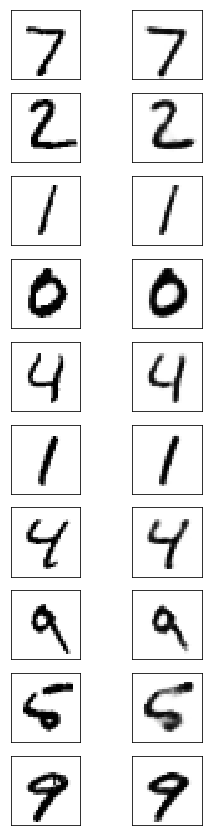

In [70]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)
images, labels = mnist.test.images, mnist.test.labels

feed_dict = {sess.graph.get_tensor_by_name(input_signature['inputs'].name): mnist.test.images[:10]}
output = sess.graph.get_tensor_by_name(output_signature['outputs'].name)
results = sess.run(output, feed_dict=feed_dict)

fig = plt.figure(figsize=(4,15))
for i in range(10):
        subplot = fig.add_subplot(10,2,i*2+1)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(images[i].reshape((28,28)), vmin=0, vmax=1,
                       cmap=plt.cm.gray_r, interpolation="nearest")
        
        subplot = fig.add_subplot(10,2,i*2+2)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(results[i].reshape((28,28)), vmin=0, vmax=1,
                       cmap=plt.cm.gray_r, interpolation="nearest")

plt.show()

# HTML based prediction tool

In [71]:
input_form = """
<table>
<td style="border-style: none;">
<div style="border: solid 2px #666; width: 143px; height: 144px;">
<canvas width="140" height="140"></canvas>
</div></td>
<td style="border-style: none;">
<button onclick="clear_value()">Clear</button>
</td>
</table>
"""

javascript = """
<script type="text/Javascript">
    var pixels = [];
    for (var i = 0; i < 28*28; i++) pixels[i] = 0
    var click = 0;

    var canvas = document.querySelector("canvas");
    canvas.addEventListener("mousemove", function(e){
        if (e.buttons == 1) {
            click = 1;
            canvas.getContext("2d").fillStyle = "rgb(0,0,0)";
            canvas.getContext("2d").fillRect(e.offsetX, e.offsetY, 8, 8);
            x = Math.floor(e.offsetY * 0.2)
            y = Math.floor(e.offsetX * 0.2) + 1
            for (var dy = 0; dy < 2; dy++){
                for (var dx = 0; dx < 2; dx++){
                    if ((x + dx < 28) && (y + dy < 28)){
                        pixels[(y+dy)+(x+dx)*28] = 1
                    }
                }
            }
        } else {
            if (click == 1) set_value()
            click = 0;
        }
    });
    
    function set_value(){
        var result = ""
        for (var i = 0; i < 28*28; i++) result += pixels[i] + ","
        var kernel = IPython.notebook.kernel;
        kernel.execute("image = [" + result + "]");
    }
    
    function clear_value(){
        canvas.getContext("2d").fillStyle = "rgb(255,255,255)";
        canvas.getContext("2d").fillRect(0, 0, 140, 140);
        for (var i = 0; i < 28*28; i++) pixels[i] = 0
    }
</script>
"""

In [93]:
from IPython.display import HTML
HTML(input_form + javascript)

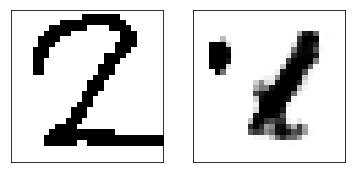

Differnce :133.149799809


In [110]:
feed_dict = {sess.graph.get_tensor_by_name(input_signature['inputs'].name):[image]}
output = sess.graph.get_tensor_by_name(output_signature['outputs'].name)
results = sess.run(output, feed_dict=feed_dict)

fig = plt.figure(figsize=(6,3))

subplot = fig.add_subplot(1,2,1)
subplot.set_xticks([])
subplot.set_yticks([])
subplot.imshow(np.array(image).reshape((28,28)), vmin=0, vmax=1,
                       cmap=plt.cm.gray_r, interpolation="nearest")
        
subplot = fig.add_subplot(1,2,2)
subplot.set_xticks([])
subplot.set_yticks([])
subplot.imshow(results[0].reshape((28,28)), vmin=0, vmax=1,
                       cmap=plt.cm.gray_r, interpolation="nearest")

plt.show()

loss = tf.reduce_sum(tf.square(results[0] - image))
loss_val = sess.run(loss)
print("Differnce :"+str(loss_val))